In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import preprocessing
import scipy.stats as st
from collections import Counter
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from functions import *
import seaborn as sns
from scipy.stats import ks_2samp

# Table of Contents

* [I.Nettoyage de données](#chapter1)
    * [1) Datas income - gdpppp](#section_1_1)
    * [2) Gini](#section_1_2)
    * [3) Population 2008 - pour 100 personnes](#section_1_3)
* [II. Mission 1 ](#chapter2)
* [III. Mission 2 ](#chapter3)
    * [1) Choix des pays par clustering](#section_3_1)
    * [2) Courbes et analyses](#section_3_2)
* [IV. Mission 3 ](#chapter4)
    * [1) Imputation des IGEincome](#section_4_1)
    * [2) Génération de la classe de revenus des parents](#section_4_2)
    * [3) Imputation de la moyenne des indices de GINI ](#section_4_3)
    * [4) Analyses](#section_4_4)
    * [5) Création de la classe parents](#section_4_5)
* [IV. Mission 4 ](#chapter5)
    * [1) ANOVA area - Income](#section_5_1)
    * [2) ANOVA area - income_log](#section_5_2)
    * [3) Régression linéaire income_log ~ gdpppp_log + Gini ](#section_5_3)
    * [4) Régression linéaire income ~ gdpppp_log + Gini](#section_5_4)

# I. Nettoyage de données <a class="anchor" id="chapter1"></a>

## 1) Datas income - gdpppp <a class="anchor" id="section_1_1"></a>

In [2]:
data = pd.read_csv("data_P7.csv")
data["income"] = [float(str(i).replace(",",".")) for i in data["income"]]
data["gdpppp"] = [float(str(i).replace(",",".")) for i in data["gdpppp"]]
data.loc[:,['income']] = data['income'].astype(float)
data.loc[:,['gdpppp']] = data['gdpppp'].astype(float)
data

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.00000
1,ALB,2008,2,100,916.66235,7297.00000
2,ALB,2008,3,100,1010.91600,7297.00000
3,ALB,2008,4,100,1086.90780,7297.00000
4,ALB,2008,5,100,1132.69970,7297.00000
...,...,...,...,...,...,...
11594,COD,2008,96,100,810.62330,303.19305
11595,COD,2008,97,100,911.78340,303.19305
11596,COD,2008,98,100,1057.80740,303.19305
11597,COD,2008,99,100,1286.60290,303.19305


In [3]:
france = data [ (data["country"] == 'FRA')]
france

,country,year_survey,quantile,nb_quantiles,income,gdpppp
3300,FRA,2008,1,100,2958.3040,30357.0
3301,FRA,2008,2,100,4412.6753,30357.0
3302,FRA,2008,3,100,4939.6350,30357.0
3303,FRA,2008,4,100,5422.9165,30357.0
3304,FRA,2008,5,100,5906.5376,30357.0
...,...,...,...,...,...,...
3395,FRA,2008,96,100,39873.5100,30357.0
3396,FRA,2008,97,100,43693.0350,30357.0
3397,FRA,2008,98,100,49489.5820,30357.0
3398,FRA,2008,99,100,60758.6130,30357.0


In [4]:
data = data.drop_duplicates()
data

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.00000
1,ALB,2008,2,100,916.66235,7297.00000
2,ALB,2008,3,100,1010.91600,7297.00000
3,ALB,2008,4,100,1086.90780,7297.00000
4,ALB,2008,5,100,1132.69970,7297.00000
...,...,...,...,...,...,...
11594,COD,2008,96,100,810.62330,303.19305
11595,COD,2008,97,100,911.78340,303.19305
11596,COD,2008,98,100,1057.80740,303.19305
11597,COD,2008,99,100,1286.60290,303.19305


In [5]:
year_survey_nan = data[data['year_survey'].isna()]
nb_quantiles_nan = data[data['nb_quantiles'].isna()]
income_nan = data[data['income'].isna()]
gdp_nan = data[data['gdpppp'].isna()]
gdp_nan = gdp_nan['country'].value_counts()
gdp_nan

XKX    100
PSE    100
Name: country, dtype: int64

In [6]:
# Imputation GDPPP Kosovo 2008 selon https://data.worldbank.org/ : 7249

data.loc[data['country'] == 'XKX', 'gdpppp'] = 7249
XKX = data[(data["country"] == 'XKX')]
XKX

,country,year_survey,quantile,nb_quantiles,income,gdpppp
5800,XKX,2008,1,100,437.89370,7249.0
5801,XKX,2008,2,100,508.17133,7249.0
5802,XKX,2008,3,100,591.82820,7249.0
5803,XKX,2008,4,100,668.00000,7249.0
5804,XKX,2008,5,100,730.40220,7249.0
...,...,...,...,...,...,...
5895,XKX,2008,96,100,5155.36470,7249.0
5896,XKX,2008,97,100,5689.52930,7249.0
5897,XKX,2008,98,100,6233.73930,7249.0
5898,XKX,2008,99,100,7366.67700,7249.0


In [7]:
# Imputation GDPPP Palestine 2008 selon https://data.worldbank.org/ : 3708

data.loc[data['country'] == 'PSE', 'gdpppp'] = 3708
PSE = data[(data["country"] == 'PSE')]
PSE

,country,year_survey,quantile,nb_quantiles,income,gdpppp
11199,PSE,2009,1,100,195.28990,3708.0
11200,PSE,2009,2,100,264.36533,3708.0
11201,PSE,2009,3,100,301.44672,3708.0
11202,PSE,2009,4,100,329.83392,3708.0
11203,PSE,2009,5,100,348.76495,3708.0
...,...,...,...,...,...,...
11294,PSE,2009,96,100,2763.88480,3708.0
11295,PSE,2009,97,100,3077.83330,3708.0
11296,PSE,2009,98,100,3449.22240,3708.0
11297,PSE,2009,99,100,4165.99700,3708.0


In [8]:
data.describe(include='all')

,country,year_survey,quantile,nb_quantiles,income,gdpppp
count,11599,11599.000000,11599.000000,11599.0,11599.000000,1.159900e+04
unique,116,NaN,NaN,NaN,NaN,NaN
top,DEU,NaN,NaN,NaN,NaN,NaN
freq,100,NaN,NaN,NaN,NaN,NaN
mean,NaN,2007.982757,50.500819,100.0,6069.224260,4.944978e+04
std,NaN,0.909633,28.868424,0.0,9414.185972,3.966471e+05
min,NaN,2004.000000,1.000000,100.0,16.719418,3.031931e+02
25%,NaN,2008.000000,25.500000,100.0,900.685515,2.577000e+03
50%,NaN,2008.000000,51.000000,100.0,2403.244900,7.505000e+03
75%,NaN,2008.000000,75.500000,100.0,7515.420900,1.838850e+04


In [9]:
# 4300332.0 : Valeur abérante

gdppp = data[(data['gdpppp'] == 4.300332e+06)]
gdppp

,country,year_survey,quantile,nb_quantiles,income,gdpppp
3200,FJI,2008,1,100,308.17334,4300332.0
3201,FJI,2008,2,100,384.33230,4300332.0
3202,FJI,2008,3,100,436.59265,4300332.0
3203,FJI,2008,4,100,486.81436,4300332.0
3204,FJI,2008,5,100,520.19720,4300332.0
...,...,...,...,...,...,...
3295,FJI,2008,96,100,5481.08200,4300332.0
3296,FJI,2008,97,100,6205.61400,4300332.0
3297,FJI,2008,98,100,7265.12550,4300332.0
3298,FJI,2008,99,100,9553.19200,4300332.0


In [10]:
# Remplacement gdpppp des Fiji 2008 selon https://data.worldbank.org/ : 7777

data.loc[data['country'] == 'FJI', 'gdpppp'] = 7777
FJI = data[(data["country"] == 'FJI')]
FJI

,country,year_survey,quantile,nb_quantiles,income,gdpppp
3200,FJI,2008,1,100,308.17334,7777.0
3201,FJI,2008,2,100,384.33230,7777.0
3202,FJI,2008,3,100,436.59265,7777.0
3203,FJI,2008,4,100,486.81436,7777.0
3204,FJI,2008,5,100,520.19720,7777.0
...,...,...,...,...,...,...
3295,FJI,2008,96,100,5481.08200,7777.0
3296,FJI,2008,97,100,6205.61400,7777.0
3297,FJI,2008,98,100,7265.12550,7777.0
3298,FJI,2008,99,100,9553.19200,7777.0


In [11]:
data.describe(include='all')

,country,year_survey,quantile,nb_quantiles,income,gdpppp
count,11599,11599.000000,11599.000000,11599.0,11599.000000,11599.000000
unique,116,NaN,NaN,NaN,NaN,NaN
top,DEU,NaN,NaN,NaN,NaN,NaN
freq,100,NaN,NaN,NaN,NaN,NaN
mean,NaN,2007.982757,50.500819,100.0,6069.224260,12441.809542
std,NaN,0.909633,28.868424,0.0,9414.185972,13095.240417
min,NaN,2004.000000,1.000000,100.0,16.719418,303.193050
25%,NaN,2008.000000,25.500000,100.0,900.685515,2577.000000
50%,NaN,2008.000000,51.000000,100.0,2403.244900,7505.000000
75%,NaN,2008.000000,75.500000,100.0,7515.420900,17787.500000


In [12]:
# 73127.000000 : Valeur abérante

gdppp = data[(data['gdpppp'] == 73127.000000)]
gdppp

,country,year_survey,quantile,nb_quantiles,income,gdpppp
6299,LUX,2008,1,100,5780.8374,73127.0
6300,LUX,2008,2,100,7315.2686,73127.0
6301,LUX,2008,3,100,7891.2456,73127.0
6302,LUX,2008,4,100,8312.0310,73127.0
6303,LUX,2008,5,100,8945.6380,73127.0
...,...,...,...,...,...,...
6394,LUX,2008,96,100,53724.6300,73127.0
6395,LUX,2008,97,100,58382.3120,73127.0
6396,LUX,2008,98,100,65280.2200,73127.0
6397,LUX,2008,99,100,77673.3700,73127.0


In [13]:
# 11599 quantiles au lieu de 11600

# 1) Trouver le pays concerné par le quantile manquant

count_country = data.groupby('country').count()
count_country = count_country.loc[~count_country["income"].isin([100])]
count_country

,year_survey,quantile,nb_quantiles,income,gdpppp
country,,,,,
LTU,99,99,99,99,99


In [14]:
# 2) Trouver le quantile manquant 

miss_q = data[(data['country'] == "LTU")|(data['country'] == "LUX")]
miss_q = miss_q.loc[:,['quantile']]
miss_q = miss_q.drop_duplicates(keep=False)
miss_q

,quantile
6339,41


In [15]:
# 3) Trouver la valeur du quantile manquant 

XY_LTU = data[(data['country'] == "LTU")].loc[:,['quantile','income']]
Y = XY_LTU['income']
X = XY_LTU[['quantile']]
X = X.copy() 
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['quantile'],result.params['intercept']
Q_manquant = a*41+b
Q_manquant

5365.885526903029

In [16]:
# 4) Imputer le quantile 41

LTU = data[(data['country'] == "LTU")]
LTU

,country,year_survey,quantile,nb_quantiles,income,gdpppp
6200,LTU,2008,1,100,566.3453,17571.0
6201,LTU,2008,2,100,1147.0587,17571.0
6202,LTU,2008,3,100,1490.8408,17571.0
6203,LTU,2008,4,100,1746.5715,17571.0
6204,LTU,2008,5,100,1842.9542,17571.0
...,...,...,...,...,...,...
6294,LTU,2008,96,100,14597.0360,17571.0
6295,LTU,2008,97,100,15659.0080,17571.0
6296,LTU,2008,98,100,17883.8770,17571.0
6297,LTU,2008,99,100,22551.1700,17571.0


In [17]:
data = data.append({'country' : 'LTU' , 'year_survey' : 2008, 'quantile' : 41, 'nb_quantiles' : 100, 'income' : 5365.8855, 'gdpppp' : 17571.0 } , ignore_index=True)
data

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.00000
1,ALB,2008,2,100,916.66235,7297.00000
2,ALB,2008,3,100,1010.91600,7297.00000
3,ALB,2008,4,100,1086.90780,7297.00000
4,ALB,2008,5,100,1132.69970,7297.00000
...,...,...,...,...,...,...
11595,COD,2008,97,100,911.78340,303.19305
11596,COD,2008,98,100,1057.80740,303.19305
11597,COD,2008,99,100,1286.60290,303.19305
11598,COD,2008,100,100,2243.12260,303.19305


In [18]:
data.describe(include='all')

,country,year_survey,quantile,nb_quantiles,income,gdpppp
count,11600,11600.000000,11600.000000,11600.0,11600.000000,11600.000000
unique,116,NaN,NaN,NaN,NaN,NaN
top,DEU,NaN,NaN,NaN,NaN,NaN
freq,100,NaN,NaN,NaN,NaN,NaN
mean,NaN,2007.982759,50.500000,100.0,6069.163627,12442.251713
std,NaN,0.909593,28.867314,0.0,9413.782409,13094.762505
min,NaN,2004.000000,1.000000,100.0,16.719418,303.193050
25%,NaN,2008.000000,25.750000,100.0,900.768508,2577.500000
50%,NaN,2008.000000,50.500000,100.0,2403.492950,7532.500000
75%,NaN,2008.000000,75.250000,100.0,7515.313700,17679.250000


In [19]:
data.groupby('year_survey').count()

,country,quantile,nb_quantiles,income,gdpppp
year_survey,,,,,
2004,100,100,100,100,100
2006,500,500,500,500,500
2007,1500,1500,1500,1500,1500
2008,7600,7600,7600,7600,7600
2009,1200,1200,1200,1200,1200
2010,600,600,600,600,600
2011,100,100,100,100,100


## 2) Gini <a class="anchor" id="section_1_2"></a>

In [20]:
gini = pd.read_excel("gini_exc.xlsx")
gini = gini.dropna(axis=1, how='all')
gini = gini.drop(columns=['Indicator Name', 'Indicator Code'])
gini.rename(columns={'Country Code': 'country'}, inplace=True)
gini.rename(columns={'Country Name': 'Area'}, inplace=True)
gini.drop(gini.columns[2:29],axis=1,inplace=True)
gini

,Area,country,2000,2001,2002,2003,2004,2005,2006,2007,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.3,NaN
3,Albania,ALB,NaN,NaN,31.7,NaN,NaN,30.6,NaN,NaN,...,NaN,NaN,29.0,NaN,34.6,32.9,33.7,33.2,NaN,NaN
4,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,NaN,NaN,NaN,29.0,NaN,31.2,30.3,NaN,...,33.3,27.8,29.0,26.3,27.3,26.5,26.7,29.0,NaN,NaN
260,"Yemen, Rep.",YEM,NaN,NaN,NaN,NaN,NaN,34.7,NaN,NaN,...,NaN,NaN,NaN,NaN,36.7,NaN,NaN,NaN,NaN,NaN
261,South Africa,ZAF,57.8,NaN,NaN,NaN,NaN,64.8,NaN,NaN,...,63.4,NaN,NaN,NaN,63.0,NaN,NaN,NaN,NaN,NaN
262,Zambia,ZMB,NaN,NaN,42.1,NaN,54.3,NaN,54.6,NaN,...,55.6,NaN,NaN,NaN,NaN,57.1,NaN,NaN,NaN,NaN


In [21]:
gini = gini.drop_duplicates()
gini

,Area,country,2000,2001,2002,2003,2004,2005,2006,2007,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.3,NaN
3,Albania,ALB,NaN,NaN,31.7,NaN,NaN,30.6,NaN,NaN,...,NaN,NaN,29.0,NaN,34.6,32.9,33.7,33.2,NaN,NaN
4,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,NaN,NaN,NaN,29.0,NaN,31.2,30.3,NaN,...,33.3,27.8,29.0,26.3,27.3,26.5,26.7,29.0,NaN,NaN
260,"Yemen, Rep.",YEM,NaN,NaN,NaN,NaN,NaN,34.7,NaN,NaN,...,NaN,NaN,NaN,NaN,36.7,NaN,NaN,NaN,NaN,NaN
261,South Africa,ZAF,57.8,NaN,NaN,NaN,NaN,64.8,NaN,NaN,...,63.4,NaN,NaN,NaN,63.0,NaN,NaN,NaN,NaN,NaN
262,Zambia,ZMB,NaN,NaN,42.1,NaN,54.3,NaN,54.6,NaN,...,55.6,NaN,NaN,NaN,NaN,57.1,NaN,NaN,NaN,NaN


In [22]:
gini.describe(include='all')

,Area,country,2000,2001,2002,2003,2004,2005,2006,2007,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
count,264,264,50.000000,36.000000,53.000000,59.000000,70.000000,76.000000,75.000000,70.000000,...,83.000000,77.000000,84.000000,76.000000,84.000000,82.000000,81.000000,72.000000,64.000000,22.000000
unique,264,264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Low income,HUN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,40.598000,43.188889,41.867925,39.391525,37.935714,39.132895,37.734667,36.515714,...,36.506024,36.216883,36.359524,36.452632,36.510714,36.796341,36.228395,35.947222,35.546875,40.972727
std,NaN,NaN,10.167385,9.502414,9.642849,9.884301,9.288719,9.301919,8.894798,8.078413,...,8.145107,7.859011,7.351733,7.347171,7.962957,7.872839,7.489663,7.399371,7.487386,8.046897
min,NaN,NaN,23.800000,29.000000,25.300000,25.300000,24.800000,24.600000,24.400000,24.400000,...,24.800000,24.600000,24.700000,24.600000,24.000000,25.400000,24.800000,24.200000,24.600000,25.300000
25%,NaN,NaN,33.025000,35.975000,34.800000,31.600000,30.525000,31.875000,30.250000,31.100000,...,30.400000,30.500000,30.275000,30.775000,31.125000,31.725000,31.200000,30.225000,29.675000,36.475000
50%,NaN,NaN,38.050000,40.900000,40.700000,37.500000,34.600000,37.550000,35.400000,34.600000,...,34.100000,34.300000,35.500000,36.200000,34.950000,35.750000,35.000000,35.350000,34.900000,41.750000
75%,NaN,NaN,50.600000,51.750000,49.700000,46.950000,44.750000,46.200000,44.800000,40.175000,...,41.300000,42.300000,41.125000,40.550000,40.675000,41.175000,41.100000,40.875000,41.325000,47.575000


## 3) Population 2008 - pour 100 personnes <a class="anchor" id="section_1_3"></a>

In [23]:
population = pd.read_csv("population_2008.csv")
population = population.loc[:,['Value','Area']]
population

,Value,Area
0,27722.276,Afghanistan
1,3002.678,Albania
2,34730.608,Algeria
3,57.492,American Samoa
4,83.862,Andorra
...,...,...
226,13.578,Wallis and Futuna Islands
227,468.633,Western Sahara
228,21892.146,Yemen
229,12848.530,Zambia


In [24]:
population.describe(include='all')

,Value,Area
count,2.310000e+02,231
unique,NaN,231
top,NaN,Qatar
freq,NaN,1
mean,3.538127e+04,NaN
std,1.520244e+05,NaN
min,7.940000e-01,NaN
25%,4.067280e+02,NaN
50%,4.775804e+03,NaN
75%,1.979478e+04,NaN


In [25]:
pop_fr = population [ (population["Area"] == 'France')]
pop_fr

,Value,Area
75,62209.207,France


In [26]:
data_gini = pd.merge(data, gini, how='left')
data_gini = pd.merge(data_gini, population, how='left')
data_gini

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Area,2000,2001,2002,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Value
0,ALB,2008,1,100,728.89795,7297.00000,Albania,NaN,NaN,31.7,...,NaN,29.0,NaN,34.6,32.9,33.7,33.2,NaN,NaN,3002.678
1,ALB,2008,2,100,916.66235,7297.00000,Albania,NaN,NaN,31.7,...,NaN,29.0,NaN,34.6,32.9,33.7,33.2,NaN,NaN,3002.678
2,ALB,2008,3,100,1010.91600,7297.00000,Albania,NaN,NaN,31.7,...,NaN,29.0,NaN,34.6,32.9,33.7,33.2,NaN,NaN,3002.678
3,ALB,2008,4,100,1086.90780,7297.00000,Albania,NaN,NaN,31.7,...,NaN,29.0,NaN,34.6,32.9,33.7,33.2,NaN,NaN,3002.678
4,ALB,2008,5,100,1132.69970,7297.00000,Albania,NaN,NaN,31.7,...,NaN,29.0,NaN,34.6,32.9,33.7,33.2,NaN,NaN,3002.678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11595,COD,2008,97,100,911.78340,303.19305,"Congo, Dem. Rep.",NaN,NaN,NaN,...,NaN,42.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11596,COD,2008,98,100,1057.80740,303.19305,"Congo, Dem. Rep.",NaN,NaN,NaN,...,NaN,42.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11597,COD,2008,99,100,1286.60290,303.19305,"Congo, Dem. Rep.",NaN,NaN,NaN,...,NaN,42.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11598,COD,2008,100,100,2243.12260,303.19305,"Congo, Dem. Rep.",NaN,NaN,NaN,...,NaN,42.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Echantillon découpé en centiles  
 1) Plus on échantillonne, plus on apprend sur la population  
 2) Si on ne mesure qu’une partie des poissons, notre résultat sera une extrapolation et sera donc entouré d’incertitudes. 

# II. Mission 1 <a class="anchor" id="chapter2"></a>

In [27]:
# Année(s) des données utilisées

nb_années = data['year_survey'].value_counts()
nb_années

2008    7600
2007    1500
2009    1200
2010     600
2006     500
2004     100
2011     100
Name: year_survey, dtype: int64

In [28]:
# Nombre de pays présents

nb_pays = data['country'].nunique()
nb_pays

116

In [29]:
population_nan = data_gini.loc[:,['Area','Value']]
population_nan = population_nan.drop_duplicates()
population_nan = population_nan[population_nan['Value'].isna()]
population_nan

,Area,Value
1100,Bolivia,NaN
1800,Cote d'Ivoire,NaN
2300,Czech Republic,NaN
2800,"Egypt, Arab Rep.",NaN
3400,United Kingdom,NaN
4600,"Iran, Islamic Rep.",NaN
5500,Kyrgyz Republic,NaN
5700,"Korea, Rep.",NaN
5800,Kosovo,NaN
5900,Lao PDR,NaN


In [30]:
NaN_Area = data_gini[data_gini['Area'].isna()]
NaN_Area

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Area,2000,2001,2002,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Value
10399,TWN,2008,1,100,3477.1800,25342.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10400,TWN,2008,2,100,4740.2637,25342.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10401,TWN,2008,3,100,5331.3013,25342.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10402,TWN,2008,4,100,5761.6577,25342.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10403,TWN,2008,5,100,6093.2017,25342.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10494,TWN,2008,96,100,38123.4600,25342.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10495,TWN,2008,97,100,41663.7900,25342.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10496,TWN,2008,98,100,46650.5820,25342.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10497,TWN,2008,99,100,54016.9920,25342.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# Calcul de GINI pour Taïwan 
gin_t = NaN_Area['income'].values
n = len(gin_t)
lorenz = np.cumsum(np.sort(gin_t)) / gin_t.sum()
lorenz = np.append([0],lorenz) 
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini_t = 2*S
gini_t

0.3148013847669253

In [32]:
Taïwan = population[population['Area'].str.contains('Ta', na=False)]
Taïwan

,Value,Area
46,23019.045,"China, Taiwan Province of"
202,7209.930,Tajikistan
218,41853.944,United Republic of Tanzania


In [33]:
# Ajout de Taïwan dans Gini
gini = gini.append({'country' : 'TWN' , 'Area' : 'China, Taiwan Province of', 2008 : 31.4 } , ignore_index=True)
gini

,Area,country,2000,2001,2002,2003,2004,2005,2006,2007,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.3,NaN
3,Albania,ALB,NaN,NaN,31.7,NaN,NaN,30.6,NaN,NaN,...,NaN,NaN,29.0,NaN,34.6,32.9,33.7,33.2,NaN,NaN
4,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,"Yemen, Rep.",YEM,NaN,NaN,NaN,NaN,NaN,34.7,NaN,NaN,...,NaN,NaN,NaN,NaN,36.7,NaN,NaN,NaN,NaN,NaN
261,South Africa,ZAF,57.8,NaN,NaN,NaN,NaN,64.8,NaN,NaN,...,63.4,NaN,NaN,NaN,63.0,NaN,NaN,NaN,NaN,NaN
262,Zambia,ZMB,NaN,NaN,42.1,NaN,54.3,NaN,54.6,NaN,...,55.6,NaN,NaN,NaN,NaN,57.1,NaN,NaN,NaN,NaN
263,Zimbabwe,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,43.2,NaN,NaN,NaN,NaN,NaN,44.3,NaN,50.3


In [34]:
Bolivia = population[population['Area'].str.contains('Bolivia', na=False)]
Bolivia

,Value,Area
24,9721.454,Bolivia (Plurinational State of)


In [35]:
Côte_Ivoire = population[population['Area'].str.contains('Ivoire', na=False)]
Côte_Ivoire

,Value,Area
52,19605.569,Côte d'Ivoire


In [36]:
Czech = population[population['Area'].str.contains('Czech', na=False)]
Czech

,Value,Area
56,10425.266,Czechia


In [37]:
Egypt = population[population['Area'].str.contains('Egypt', na=False)]
Egypt

,Value,Area
64,79636.079,Egypt


In [38]:
Kingdom = population[population['Area'].str.contains('Kingdom', na=False)]
Kingdom

,Value,Area
217,62145.097,United Kingdom of Great Britain and Northern I...


In [39]:
Iran = population[population['Area'].str.contains('Iran', na=False)]
Iran

,Value,Area
100,72120.604,Iran (Islamic Republic of)


In [40]:
Kyrgyz = population[population['Area'].str.contains('Kyrgyz', na=False)]
Kyrgyz

,Value,Area
113,5254.979,Kyrgyzstan


In [41]:
Korea = population[population['Area'].str.contains('Korea', na=False)]
Korea

,Value,Area
57,24310.142,Democratic People's Republic of Korea
170,49182.456,Republic of Korea


In [42]:
Kosovo = population[population['Area'].str.contains('Kosovo', na=False)]
Kosovo

,Value,Area


In [43]:
Lao = population[population['Area'].str.contains('Lao', na=False)]
Lao

,Value,Area
114,6046.62,Lao People's Democratic Republic


In [44]:
Moldova = population[population['Area'].str.contains('Moldova', na=False)]
Moldova

,Value,Area
171,4112.891,Republic of Moldova


In [45]:
Sudan = population[population['Area'].str.contains('Sudan', na=False)]
Sudan

,Value,Area
197,41797.776,Sudan (former)


In [46]:
Slovak = population[population['Area'].str.contains('Slovak', na=False)]
Slovak

,Value,Area
190,5399.371,Slovakia


In [47]:
Tanzania = population[population['Area'].str.contains('Tanzania', na=False)]
Tanzania

,Value,Area
218,41853.944,United Republic of Tanzania


In [48]:
United = population[population['Area'].str.contains('United', na=False)]
United

,Value,Area
216,7089.487,United Arab Emirates
217,62145.097,United Kingdom of Great Britain and Northern I...
218,41853.944,United Republic of Tanzania
219,303486.012,United States of America
220,106.756,United States Virgin Islands


In [49]:
Venezuela = population[population['Area'].str.contains('Venezuela', na=False)]
Venezuela

,Value,Area
224,27635.832,Venezuela (Bolivarian Republic of)


In [50]:
Vietnam = population[population['Area'].str.contains('Viet', na=False)]
Vietnam

,Value,Area
225,86243.413,Viet Nam


In [51]:
Gaza = population[population['Area'].str.contains('Gaza', na=False)]
Gaza

,Value,Area


In [52]:
Yemen = population[population['Area'].str.contains('Yemen', na=False)]
Yemen

,Value,Area
228,21892.146,Yemen


In [53]:
Congo = population[population['Area'].str.contains('Congo', na=False)]
Congo

,Value,Area
49,4011.486,Congo
58,60411.195,Democratic Republic of the Congo


In [54]:
Palestine = population[population['Area'].str.contains('Pales', na=False)]
Palestine

,Value,Area
160,3856.679,Palestine


In [55]:
West = population[population['Area'].str.contains('West', na=False)]
population

,Value,Area
0,27722.276,Afghanistan
1,3002.678,Albania
2,34730.608,Algeria
3,57.492,American Samoa
4,83.862,Andorra
...,...,...
226,13.578,Wallis and Futuna Islands
227,468.633,Western Sahara
228,21892.146,Yemen
229,12848.530,Zambia


In [56]:
population['Area'] = population['Area'].replace(['Bolivia (Plurinational State of)','Côte d\'Ivoire','Czechia','Egypt','United Kingdom of Great Britain and Northern Ireland','Iran (Islamic Republic of)','Kyrgyzstan','Republic of Korea','Lao People\'s Democratic Republic','Republic of Moldova','Sudan (former)','Slovakia','United Republic of Tanzania','United States of America','Venezuela (Bolivarian Republic of)','Viet Nam','Palestine','Yemen','Democratic Republic of the Congo'],['Bolivia','Cote d\'Ivoire','Czech Republic','Egypt, Arab Rep.','United Kingdom','Iran, Islamic Rep.','Kyrgyz Republic','Korea, Rep.','Lao PDR','Moldova','Sudan','Slovak Republic','Tanzania','United States','Venezuela, RB','Vietnam','West Bank and Gaza','Yemen, Rep.','Congo, Dem. Rep.',])
population.head(60)

,Value,Area
0,27722.276,Afghanistan
1,3002.678,Albania
2,34730.608,Algeria
3,57.492,American Samoa
4,83.862,Andorra
5,21695.634,Angola
6,13.063,Anguilla
7,85.397,Antigua and Barbuda
8,40080.160,Argentina
9,2907.618,Armenia


In [57]:
data_gini = pd.merge(data, gini, how='left')
data_gini = pd.merge(data_gini, population, how='left')
population_nan = data_gini.loc[:,['Area','Value']]
population_nan = population_nan.drop_duplicates()
population_nan = population_nan[population_nan['Value'].isna()]
population_nan

,Area,Value
5800,Kosovo,NaN


In [58]:
# Imputation de la population du Kosovo 1 768 673 hab / 2018

population = population.append({'Value' : 1768.673 , 'Area' : 'Kosovo'} , ignore_index=True)

In [59]:
# Pourcentage population étude / Population mondiale en 2008 -  6700000.000

pop_tot = data_gini.loc[:,['Area','Value']]
pop_tot = pop_tot.drop_duplicates()
pop_tot = pop_tot['Value'].sum()
pop_tot

6272355.014999999

In [60]:
pop_pourcentage = pop_tot / 6700000.000*100
pop_pourcentage

93.61723902985074

# III. Mission 2 <a class="anchor" id="chapter3"></a>

## 1) Choix des pays par clustering <a class="anchor" id="section_3_1"></a>

In [61]:
quart_k = data_gini.loc[:,['Area','income']]
quart_k = quart_k.groupby('Area', as_index=True).mean()
quart_k 

,income
Area,
Albania,2994.829902
Argentina,5847.884654
Armenia,1628.382785
Austria,16637.600204
Azerbaijan,2357.429023
...,...
Uruguay,5290.784920
"Venezuela, RB",3167.147724
Vietnam,1377.773966


In [62]:
# préparation des données pour le clustering
X = quart_k.values
names = quart_k.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Nombre de clusters souhaités
n_clust = 4

# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X_scaled)

# Récupération des clusters attribués à chaque individu
clustersk = km.labels_
clustersk

mesure_K = quart_k.copy()
mesure_K['cluster_k'] = clustersk 
mesure_K

,income,cluster_k
Area,,
Albania,2994.829902,3
Argentina,5847.884654,1
Armenia,1628.382785,3
Austria,16637.600204,2
Azerbaijan,2357.429023,3
...,...,...
Uruguay,5290.784920,1
"Venezuela, RB",3167.147724,3
Vietnam,1377.773966,3


In [63]:
clus0 = mesure_K [ (mesure_K["cluster_k"] == 0)]
clus0

,income,cluster_k
Area,,
Canada,23739.640518,0
Iceland,26888.511518,0
Luxembourg,25217.562681,0
Norway,22483.375020,0
United Kingdom,21709.604470,0
United States,25503.581661,0


2 pays : Bulgaria & Malaysia

In [64]:
clus1 = mesure_K [ (mesure_K["cluster_k"] == 1)]
clus1

,income,cluster_k
Area,,
Argentina,5847.884654,1
Bosnia and Herzegovina,6334.687311,1
Brazil,4807.484594,1
Bulgaria,4984.978559,1
Chile,7051.609966,1
Costa Rica,5580.386556,1
Croatia,7716.465790,1
Czech Republic,8235.293411,1
Estonia,7702.062593,1


2 pays : Canada & United States

In [65]:
clus2 = mesure_K [ (mesure_K["cluster_k"] == 2)]
clus2

,income,cluster_k
Area,,
Austria,16637.600204,2
Belgium,15024.614176,2
"China, Taiwan Province of",16500.223670,2
Cyprus,17345.387463,2
Denmark,17043.146491,2
Finland,16306.330495,2
France,18309.407545,2
Germany,18061.718142,2
Greece,11727.274287,2


2 pays : Azerbaijan & Vietnam

In [66]:
clus3 = mesure_K [ (mesure_K["cluster_k"] == 3)]
clus3

,income,cluster_k
Area,,
Albania,2994.829902,3
Armenia,1628.382785,3
Azerbaijan,2357.429023,3
Bangladesh,998.692409,3
Belarus,3921.163534,3
...,...,...
Ukraine,3349.388306,3
"Venezuela, RB",3167.147724,3
Vietnam,1377.773966,3


2 pays : Belgium & Sweden

Séléction de 9 pays avec la France : Bulgaria, Malaysia, Canada, United States, Azerbaijan, Vietnam, Belgium, Sweden & France

## 2) Courbes et analyses <a class="anchor" id="section_3_2"></a>


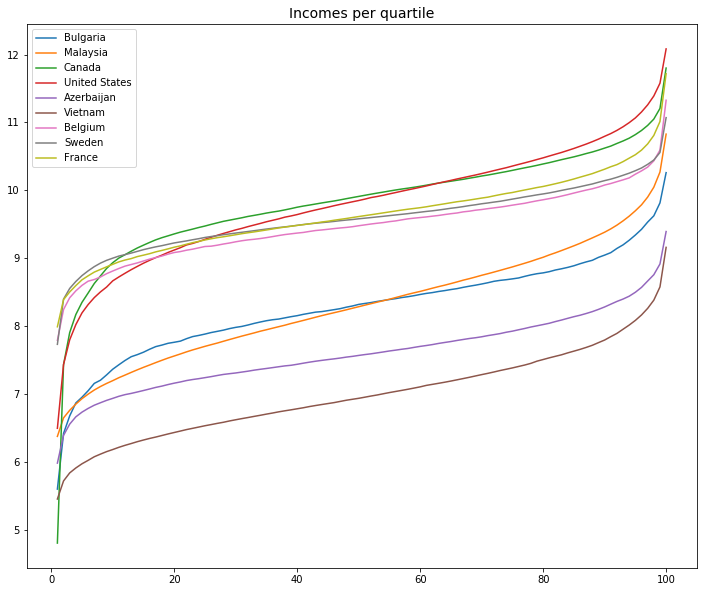

In [67]:
x = data_gini[(data_gini["Area"] == 'Bulgaria')]['quantile']
y = data_gini[(data_gini["Area"] == 'Bulgaria')]['income']
ym = data_gini[(data_gini["Area"] == 'Malaysia')]['income']
yc = data_gini[(data_gini["Area"] == 'Canada')]['income']
yu = data_gini[(data_gini["Area"] == 'United States')]['income']
ya = data_gini[(data_gini["Area"] == 'Azerbaijan')]['income']
yv = data_gini[(data_gini["Area"] == 'Vietnam')]['income']
yb = data_gini[(data_gini["Area"] == 'Belgium')]['income']
ys = data_gini[(data_gini["Area"] == 'Sweden')]['income']
yf = data_gini[(data_gini["Area"] == 'France')]['income']

plt.figure(figsize=(12, 10))
plt.title('Incomes per quartile',fontsize=14)
plt.plot(x , np.log(y) ,label='Bulgaria')
plt.plot(x , np.log(ym) ,label='Malaysia')
plt.plot(x , np.log(yc) ,label='Canada')
plt.plot(x , np.log(yu) ,label='United States')
plt.plot(x , np.log(ya) ,label='Azerbaijan')
plt.plot(x , np.log(yv) ,label='Vietnam')
plt.plot(x , np.log(yb) ,label='Belgium')
plt.plot(x , np.log(ys) ,label='Sweden')
plt.plot(x , np.log(yf) ,label='France')
plt.legend(loc="upper left")
plt.show()

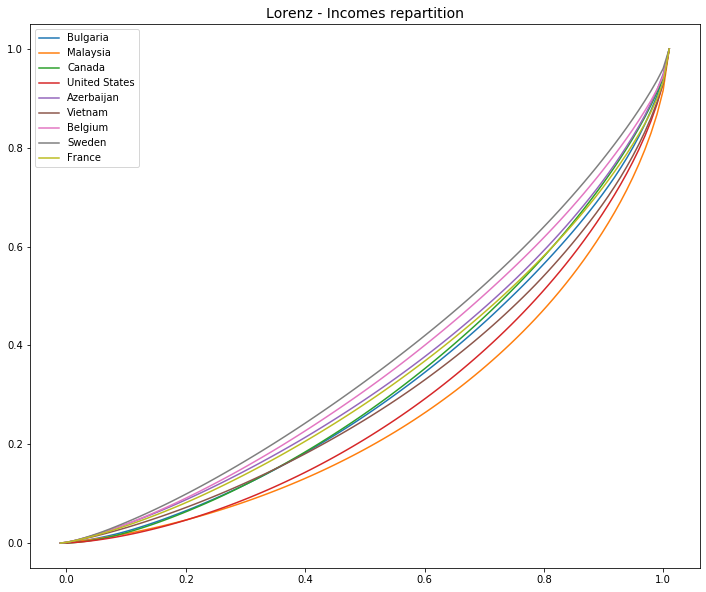

In [68]:
n = len(y)
lorenz = np.cumsum(np.sort(y)) / y.sum()
lorenz = np.append([0],lorenz) 
xaxis = np.linspace(0-1/n,1+1/n,n+1) 

lorenzm = np.cumsum(np.sort(ym)) / ym.sum()
lorenzm = np.append([0],lorenzm) 

lorenzc = np.cumsum(np.sort(yc)) / yc.sum()
lorenzc = np.append([0],lorenzc) 

lorenzu = np.cumsum(np.sort(yu)) / yu.sum()
lorenzu = np.append([0],lorenzu)

lorenza = np.cumsum(np.sort(ya)) / ya.sum()
lorenza = np.append([0],lorenza)

lorenzv = np.cumsum(np.sort(yv)) / yv.sum()
lorenzv = np.append([0],lorenzv)

lorenzb = np.cumsum(np.sort(yb)) / yb.sum()
lorenzb = np.append([0],lorenzb)

lorenzs = np.cumsum(np.sort(ys)) / ys.sum()
lorenzs = np.append([0],lorenzs)

lorenzf = np.cumsum(np.sort(yf)) / yf.sum()
lorenzf = np.append([0],lorenzf)

plt.figure(figsize=(12, 10))
plt.title('Lorenz - Incomes repartition',fontsize=14) 
plt.plot(xaxis, lorenz, label='Bulgaria')
plt.plot(xaxis, lorenzm, label='Malaysia')
plt.plot(xaxis, lorenzc, label='Canada')
plt.plot(xaxis, lorenzu, label='United States')
plt.plot(xaxis, lorenza, label='Azerbaijan')
plt.plot(xaxis, lorenzv, label='Vietnam')
plt.plot(xaxis, lorenzb, label='Belgium')
plt.plot(xaxis, lorenzs, label='Sweden')
plt.plot(xaxis, lorenzf, label='France')


plt.legend(loc="upper left")
plt.show()

In [69]:
select_gini = data_gini [ (data_gini["Area"] == 'Bulgaria')|(data_gini["Area"] == 'Malaysia')|(data_gini["Area"] == 'Canada')|(data_gini["Area"] == 'United States')|(data_gini["Area"] == 'Azerbaijan')|(data_gini["Area"] == 'Vietnam')|(data_gini["Area"] == 'Belgium')|(data_gini["Area"] == 'Sweden')|(data_gini["Area"] == 'France')]
select_gini = select_gini.iloc[:,6:27]
select_gini = select_gini.drop_duplicates()
select_gini = select_gini.set_index('Area')
select_gini

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Area,,,,,,,,,,,,,,,,,,,,
Azerbaijan,NaN,36.5,25.3,26.8,26.6,26.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Belgium,33.1,NaN,NaN,28.1,30.5,29.3,28.1,29.2,28.4,28.6,28.4,28.1,27.5,27.7,28.1,27.7,27.6,27.4,27.2,NaN
Bulgaria,NaN,NaN,NaN,NaN,NaN,NaN,35.7,36.1,33.6,33.8,35.7,34.3,36.0,36.6,37.4,38.6,40.6,40.4,41.3,NaN
Canada,33.3,NaN,NaN,NaN,33.7,NaN,NaN,33.8,NaN,NaN,33.6,NaN,33.5,33.8,33.2,33.7,32.7,33.3,NaN,NaN
France,31.1,NaN,NaN,31.4,30.6,29.8,29.7,32.4,33.0,32.7,33.7,33.3,33.1,32.5,32.3,32.7,31.9,31.6,32.4,NaN
Malaysia,NaN,NaN,NaN,46.4,NaN,NaN,44.8,NaN,45.5,NaN,NaN,43.9,NaN,41.3,NaN,41.1,NaN,NaN,NaN,NaN
Sweden,27.2,NaN,NaN,25.3,26.1,26.8,26.4,27.1,28.1,27.3,27.7,27.6,27.6,28.8,28.4,29.2,29.6,28.8,30.0,NaN
United States,40.1,40.6,40.4,40.8,40.3,41.0,41.4,40.8,40.8,40.6,40.0,40.9,40.9,40.7,41.5,41.2,41.1,41.2,41.4,NaN
Vietnam,NaN,NaN,37.0,NaN,36.8,NaN,35.8,NaN,35.6,NaN,39.3,NaN,35.6,NaN,34.8,NaN,35.3,NaN,35.7,NaN


In [70]:
gini_graph = select_gini.T # or select_gini.transpose()
gini_graph = gini_graph.reset_index()
gini_graph

Area,index,Azerbaijan,Belgium,Bulgaria,Canada,France,Malaysia,Sweden,United States,Vietnam
0,2000,NaN,33.1,NaN,33.3,31.1,NaN,27.2,40.1,NaN
1,2001,36.5,NaN,NaN,NaN,NaN,NaN,NaN,40.6,NaN
2,2002,25.3,NaN,NaN,NaN,NaN,NaN,NaN,40.4,37.0
3,2003,26.8,28.1,NaN,NaN,31.4,46.4,25.3,40.8,NaN
4,2004,26.6,30.5,NaN,33.7,30.6,NaN,26.1,40.3,36.8
5,2005,26.6,29.3,NaN,NaN,29.8,NaN,26.8,41.0,NaN
6,2006,NaN,28.1,35.7,NaN,29.7,44.8,26.4,41.4,35.8
7,2007,NaN,29.2,36.1,33.8,32.4,NaN,27.1,40.8,NaN
8,2008,NaN,28.4,33.6,NaN,33.0,45.5,28.1,40.8,35.6
9,2009,NaN,28.6,33.8,NaN,32.7,NaN,27.3,40.6,NaN


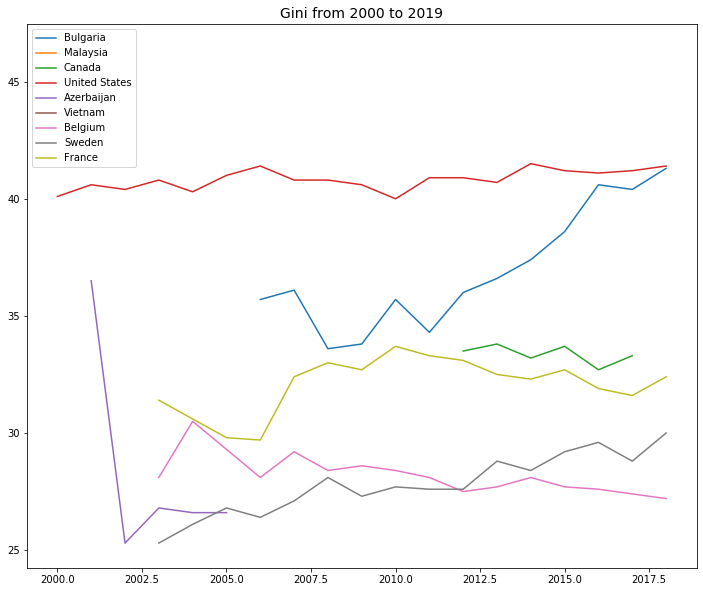

In [71]:
x = gini_graph['index']
plt.figure(figsize=(12, 10))
plt.title('Gini from 2000 to 2019',fontsize=14)

plt.plot(x , gini_graph['Bulgaria'] ,label='Bulgaria')
plt.plot(x , gini_graph['Malaysia'] ,label='Malaysia')
plt.plot(x , gini_graph['Canada'] ,label='Canada')
plt.plot(x , gini_graph['United States'] ,label='United States')
plt.plot(x , gini_graph['Azerbaijan'] ,label='Azerbaijan')
plt.plot(x , gini_graph['Vietnam'] ,label='Vietnam')
plt.plot(x , gini_graph['Belgium'] ,label='Belgium')
plt.plot(x , gini_graph['Sweden'] ,label='Sweden')
plt.plot(x , gini_graph['France'] ,label='France')

plt.legend(loc="upper left")
plt.show()

En 2007, la Bulgarie est devenue le 27ième membre de l’UE.  
Janvier 2001 : L'Azerbaïdjan devient membre du Conseil de l'Europe (ou erreur de mesure).

In [72]:
select_gini['Mean'] = gini_graph.mean()
select_gini = select_gini.sort_values(by = 'Mean', ascending = False)
select_gini

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Mean
Area,,,,,,,,,,,,,,,,,,,,,
Malaysia,NaN,NaN,NaN,46.4,NaN,NaN,44.8,NaN,45.5,NaN,...,43.9,NaN,41.3,NaN,41.1,NaN,NaN,NaN,NaN,43.833333
United States,40.1,40.6,40.4,40.8,40.3,41.0,41.4,40.8,40.8,40.6,...,40.9,40.9,40.7,41.5,41.2,41.1,41.2,41.4,NaN,40.826316
Bulgaria,NaN,NaN,NaN,NaN,NaN,NaN,35.7,36.1,33.6,33.8,...,34.3,36.0,36.6,37.4,38.6,40.6,40.4,41.3,NaN,36.930769
Vietnam,NaN,NaN,37.0,NaN,36.8,NaN,35.8,NaN,35.6,NaN,...,NaN,35.6,NaN,34.8,NaN,35.3,NaN,35.7,NaN,36.211111
Canada,33.3,NaN,NaN,NaN,33.7,NaN,NaN,33.8,NaN,NaN,...,NaN,33.5,33.8,33.2,33.7,32.7,33.3,NaN,NaN,33.460000
France,31.1,NaN,NaN,31.4,30.6,29.8,29.7,32.4,33.0,32.7,...,33.3,33.1,32.5,32.3,32.7,31.9,31.6,32.4,NaN,32.011765
Belgium,33.1,NaN,NaN,28.1,30.5,29.3,28.1,29.2,28.4,28.6,...,28.1,27.5,27.7,28.1,27.7,27.6,27.4,27.2,NaN,28.529412
Azerbaijan,NaN,36.5,25.3,26.8,26.6,26.6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.360000
Sweden,27.2,NaN,NaN,25.3,26.1,26.8,26.4,27.1,28.1,27.3,...,27.6,27.6,28.8,28.4,29.2,29.6,28.8,30.0,NaN,27.764706


# IV. Mission 3 <a class="anchor" id="chapter4"></a>

## 1) Imputation de IGEincome <a class="anchor" id="section_4_1"></a>


In [73]:
GDIM = pd.read_csv("GDIM.csv")
GDIM = GDIM.loc[:,['countryname','IGEincome']]
GDIM_unique = GDIM.drop_duplicates(keep=False)
GDIM_unique

,countryname,IGEincome
429,Bangladesh,0.538000
3556,Luxembourg,0.380792
5297,Singapore,0.260000


In [74]:
GDIM_all = GDIM.drop_duplicates()
GDIM_all

,countryname,IGEincome
0,Afghanistan,NaN
12,Angola,NaN
24,Albania,NaN
60,Albania,0.815874
84,Argentina,NaN
...,...,...
6402,South Africa,NaN
6426,South Africa,0.677000
6462,"Congo, Dem. Rep.",NaN
6480,"Congo, Dem. Rep.",0.707703


In [75]:
GDIM_all = GDIM_all[GDIM_all['countryname'].duplicated(keep=False)]
GDIM_all = GDIM_all.dropna(subset=['IGEincome'])
GDIM_all

,countryname,IGEincome
60,Albania,0.815874
183,Australia,0.275000
243,Austria,0.245267
351,Belgium,0.183176
405,Benin,0.855116
...,...,...
6202,United States,0.537666
6274,Uzbekistan,0.496764
6330,Vietnam,0.480000
6426,South Africa,0.677000


In [76]:
GDIM = pd.concat([GDIM_unique, GDIM_all])
GDIM.rename(columns={'countryname': 'Area'}, inplace=True)
GDIM = GDIM.drop_duplicates()
GDIM

,Area,IGEincome
429,Bangladesh,0.538000
3556,Luxembourg,0.380792
5297,Singapore,0.260000
60,Albania,0.815874
183,Australia,0.275000
...,...,...
6202,United States,0.537666
6274,Uzbekistan,0.496764
6330,Vietnam,0.480000
6426,South Africa,0.677000


In [77]:
data_gini = pd.merge(data_gini, GDIM, on = 'Area', how='left')
GDIM_nan = data_gini.copy()
GDIM_nan = GDIM_nan[GDIM_nan['IGEincome'].isna()]
GDIM_nan = GDIM_nan.loc[:,['Area','IGEincome']]
GDIM_nan = GDIM_nan.drop_duplicates()
col_one_list = GDIM_nan['Area'].tolist()
print(f"\ncol_one_list:\n{col_one_list}\ntype:{type(col_one_list)}")
GDIM_nan['Area'].nunique()


col_one_list:
['Argentina', 'Armenia', 'Azerbaijan', 'Burkina Faso', 'Bulgaria', 'Bhutan', 'Central African Republic', "Cote d'Ivoire", 'Cameroon', 'Costa Rica', 'Dominican Republic', 'Estonia', 'Fiji', 'Georgia', 'Honduras', 'Hungary', 'Indonesia', 'Iran, Islamic Rep.', 'Iraq', 'Iceland', 'Israel', 'Cambodia', 'Kosovo', 'Lao PDR', 'Liberia', 'Sri Lanka', 'Lithuania', 'Moldova', 'Mexico', 'North Macedonia', 'Montenegro', 'Mozambique', 'Mauritania', 'Niger', 'Nicaragua', 'Philippines', 'Poland', 'Paraguay', 'Sudan', 'El Salvador', 'Serbia', 'Eswatini', 'Syrian Arab Republic', 'Thailand', 'Tajikistan', 'Turkey', 'China, Taiwan Province of', 'Ukraine', 'Uruguay', 'Venezuela, RB', 'West Bank and Gaza', 'Yemen, Rep.']
type:<class 'list'>


52

In [78]:
data = {'Area':['Argentina', 'Armenia', 'Azerbaijan', 'Burkina Faso','Bulgaria', 'Bhutan', 'Central African Republic', "Cote d'Ivoire",'Cameroon', 'Costa Rica', 'Dominican Republic', 'Estonia', 'Fiji','Georgia', 'Honduras', 'Hungary', 'Indonesia', 'Iran, Islamic Rep.','Iraq', 'Iceland', 'Israel', 'Cambodia', 'Kosovo', 'Lao PDR', 'Liberia', 'Sri Lanka', 'Lithuania', 'Moldova', 'Mexico', 'North Macedonia', 'Montenegro', 'Mozambique', 'Mauritania', 'Niger', 'Nicaragua', 'Philippines', 'Poland', 'Paraguay', 'Sudan', 'El Salvador', 'Serbia', 'Eswatini', 'Syrian Arab Republic', 'Thailand', 'Tajikistan', 'Turkey', 'China, Taiwan Province of', 'Ukraine', 'Uruguay', 'Venezuela, RB', 'West Bank and Gaza', 'Yemen, Rep.'],'IGEincome':[0.66,0.5,0.5,0.66,0.4,0.5,0.66,0.66,0.66,0.66,0.66,0.4,0.4,0.4,0.66,0.4,0.5,0.5,0.5,0.2,0.66,0.66,0.66,0.5,0.66,0.5,0.4,0.4,0.66,0.4,0.4,0.4,0.66,0.66,0.66,0.66,0.5,0.4,0.66,0.66,0.4,0.66,0.5,0.5,0.4,0.4,0.5,0.5,0.4,0.66,0.66,0.66]}
GDIM_nan = pd.DataFrame(data=data)
GDIM_nan

,Area,IGEincome
0,Argentina,0.66
1,Armenia,0.50
2,Azerbaijan,0.50
3,Burkina Faso,0.66
4,Bulgaria,0.40
5,Bhutan,0.50
6,Central African Republic,0.66
7,Cote d'Ivoire,0.66
8,Cameroon,0.66
9,Costa Rica,0.66


In [79]:
GDIM = pd.concat([GDIM, GDIM_nan])
data_gini = data_gini.drop(['IGEincome'], axis=1)
data_gini = pd.merge(data_gini, GDIM, how='left')
data_gini['IGEincome'] = data_gini['IGEincome'].astype(float)
data_gini = data_gini.round({'IGEincome': 4})
GDIM = data_gini.loc[:,['Area','IGEincome']]

## 2) Génération de la classe de revenus des parents <a class="anchor" id="section_4_2"></a>

In [80]:
def generate_incomes(n, pj):
    # On génère les revenus des parents (exprimés en logs) selon une loi normale.
    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
    ln_y_parent = st.norm(0,1).rvs(size=n)
    # Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)
    
def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
    
    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib   

def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 

def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure()
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend()
    plt.xlabel("quantile parents")
    plt.ylabel("probabilité du quantile enfant")
    plt.show()
    
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]

pj = 0.9                 # coefficient d'élasticité du pays j
nb_quantiles = 100       # nombre de quantiles (nombre de classes de revenu)
n  = 1000*nb_quantiles   # taille de l'échantillon

In [81]:
# 1
ln_y_parent = st.norm(0,1).rvs(size=n)
ln_y_parent

array([-1.19762332, -0.11904047,  0.50583796, ...,  0.74901942,
       -1.67837532, -0.32229676])

In [82]:
# 2
residues = st.norm(0,1).rvs(size=n)
residues

array([ 0.82256295, -0.03974929, -0.48555723, ...,  1.9232175 ,
        0.40945676,  1.32570774])

In [83]:
# 3
y_child = np.exp(pj*ln_y_parent + residues)
y_child

array([ 0.77468558,  0.86339265,  0.97015147, ..., 13.42790467,
        0.33251144,  2.81691034])

In [84]:
# 4
y_parents = np.exp(ln_y_parent)
y_parents

array([0.30191091, 0.88777187, 1.6583746 , ..., 2.11492515, 0.18667702,
       0.72448316])

In [85]:
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
sample

,y_child,y_parents,c_i_child,c_i_parent
0,0.774686,0.301911,43,12
1,0.863393,0.887772,46,46
2,0.970151,1.658375,50,70
3,1.214142,2.923862,56,86
4,0.063729,0.408867,3,19
...,...,...,...,...
99995,1.817835,3.291118,68,89
99996,0.756592,5.484566,42,96
99997,13.427905,2.114925,98,78
99998,0.332511,0.186677,21,5


In [86]:
# 5
cd = conditional_distributions(sample, nb_quantiles)
cd

array([[0.23 , 0.118, 0.072, ..., 0.   , 0.   , 0.   ],
       [0.13 , 0.095, 0.072, ..., 0.   , 0.   , 0.   ],
       [0.092, 0.064, 0.072, ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.065, 0.074, 0.092],
       [0.   , 0.   , 0.   , ..., 0.073, 0.085, 0.116],
       [0.   , 0.   , 0.   , ..., 0.084, 0.104, 0.247]])

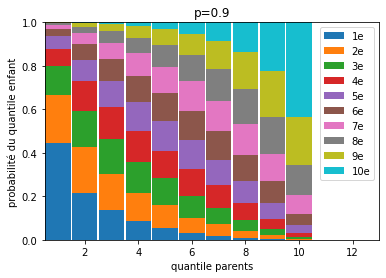

In [87]:
# 6 Très faible mobilité (0.9)
p = 0.9
nb_quantiles = 10

sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
p1 = plot_conditional_distributions(p, cd, nb_quantiles)
p1

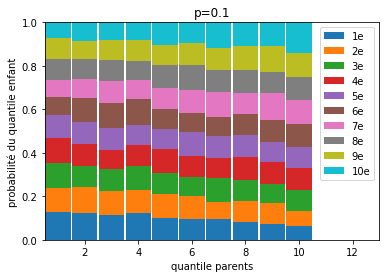

In [88]:
# Forte mobilité (0.1)
pj = 0.1                # coefficient d'élasticité du pays j
nb_quantiles = 10       # nombre de quantiles (nombre de classes de revenu)
n  = 1000*nb_quantiles  # taille de l'échantillon
p = 0.1

y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
plt_final = plot_conditional_distributions(p, cd, nb_quantiles)
plt_final

## 3) Imputation de la moyenne des indices de GINI <a class="anchor" id="section_4_3"></a>

In [89]:
# Suppression des différentes années GINI et remplacement par la moyenne 
gini_moy = data_gini.set_index('country')
gini_moy = gini_moy.iloc[:,6:17]
gini_moy = gini_moy.drop_duplicates()
gini_moy = gini_moy.T # or select_gini.transpose()
gini_moy.loc['Gini'] = gini_moy.mean()
gini_moy = gini_moy.T # or select_gini.transpose()
gini_moy = gini_moy.reset_index()
gini_moy = gini_moy.loc[:,['country','Gini']]
gini_moy_n = gini_moy[gini_moy['Gini'].isna()]
gini_moy_n

,country,Gini
56,KHM,NaN


In [90]:
missing_gini = data_gini.copy()
missing_gini = missing_gini.loc[:,['country']]
missing_gini = missing_gini.drop_duplicates()
gini_NaN = pd.merge(missing_gini, gini_moy, how='left')
gini_NaN = gini_NaN[gini_NaN['Gini'].isna()]
gini_NaN

,country,Gini
56,KHM,NaN
71,MNE,NaN
94,SRB,NaN


Imputation via données ONU

KHM = 30.8  
MNE = 31.9  
SRB = 28.2  

In [91]:
gini_moy.loc[56]=[ 'KHM', 30.8 ]
gini_moy.loc[115]=[ 'MNE', 31.9 ]
gini_moy.loc[116]=[ 'SRB', 28.2 ]
gini_moy

,country,Gini
0,ALB,30.766667
1,ARG,48.172727
2,ARM,32.480000
3,AUT,29.911111
4,AZE,28.360000
...,...,...
111,YEM,34.700000
112,ZAF,62.250000
113,COD,42.200000
115,MNE,31.900000


In [92]:
data_gini_drop = data_gini.iloc[:,7:27]
data_gini = data_gini.drop(columns = data_gini_drop)
data_gini = pd.merge(data_gini, gini_moy, how='left')
data_gini = data_gini.drop(columns=['Value', 'year_survey', 'nb_quantiles'])
data_gini.describe()

,quantile,income,gdpppp,IGEincome,Gini
count,11600.000000,11600.000000,11600.000000,11600.000000,11600.000000
mean,50.500000,6069.163627,12442.251713,0.530176,38.247310
std,28.867314,9413.782409,13094.762505,0.200125,8.295047
min,1.000000,16.719418,303.193050,0.112900,24.514286
25%,25.750000,900.768508,2577.500000,0.400000,31.888636
50%,50.500000,2403.492950,7532.500000,0.500000,36.585714
75%,75.250000,7515.313700,17679.250000,0.660000,42.725000
max,100.000000,176928.550000,73127.000000,1.095400,62.250000


## 4) Analyses <a class="anchor" id="section_4_4"></a>

In [93]:
# Contruction de l'échantillon France 

pj = data_gini[data_gini['Area'] == 'France']['IGEincome']
pj

3300    0.3571
3301    0.3571
3302    0.3571
3303    0.3571
3304    0.3571
         ...  
3395    0.3571
3396    0.3571
3397    0.3571
3398    0.3571
3399    0.3571
Name: IGEincome, Length: 100, dtype: float64

In [94]:
GDIM_FR = GDIM[GDIM['Area'] == 'France']
GDIM_FR = 0.3571
nb_quantiles = 10
n  = 1000*nb_quantiles

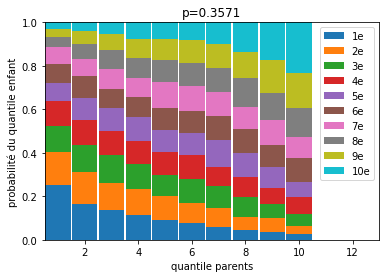

In [95]:
y_child, y_parents = generate_incomes(n, GDIM_FR)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
plt_final = plot_conditional_distributions(GDIM_FR, cd, nb_quantiles)
plt_final

In [96]:
sample_merge = sample.copy()
sample_merge.rename(columns={'c_i_child': 'quantile'}, inplace=True)
data_gini_FR = data_gini[data_gini['Area'] == 'France']
data_gini_FR = pd.merge(data_gini_FR, sample_merge, how='inner')
data_gini_FR

,country,quantile,income,gdpppp,Area,IGEincome,Gini,y_child,y_parents,c_i_parent
0,FRA,1,2958.304,30357.0,France,0.3571,31.6,0.193006,0.250799,1
1,FRA,1,2958.304,30357.0,France,0.3571,31.6,0.234404,1.665561,7
2,FRA,1,2958.304,30357.0,France,0.3571,31.6,0.216968,0.122466,1
3,FRA,1,2958.304,30357.0,France,0.3571,31.6,0.227571,0.952097,5
4,FRA,1,2958.304,30357.0,France,0.3571,31.6,0.145631,0.406090,2
...,...,...,...,...,...,...,...,...,...,...
9995,FRA,10,7419.523,30357.0,France,0.3571,31.6,4.421096,1.625430,7
9996,FRA,10,7419.523,30357.0,France,0.3571,31.6,3.947166,0.380949,2
9997,FRA,10,7419.523,30357.0,France,0.3571,31.6,11.760568,4.406767,10
9998,FRA,10,7419.523,30357.0,France,0.3571,31.6,4.399322,1.046096,6


In [97]:
data_gini = data_gini.sort_values(by='IGEincome', ascending=False)
data_gini

# Graphique forte mobilité (p(min) = 0.1129)
pmin = data_gini[data_gini['IGEincome'] == 0.1129]
pmin

,country,quantile,income,gdpppp,Area,IGEincome,Gini
3100,FIN,1,3248.9075,33626.0,Finland,0.1129,27.744444
3151,FIN,52,14423.2240,33626.0,Finland,0.1129,27.744444
3199,FIN,100,82762.2700,33626.0,Finland,0.1129,27.744444
3124,FIN,25,10555.8570,33626.0,Finland,0.1129,27.744444
3126,FIN,27,10818.7580,33626.0,Finland,0.1129,27.744444
...,...,...,...,...,...,...,...
3169,FIN,70,17835.3830,33626.0,Finland,0.1129,27.744444
3170,FIN,71,18088.0920,33626.0,Finland,0.1129,27.744444
3171,FIN,72,18311.2440,33626.0,Finland,0.1129,27.744444
3172,FIN,73,18546.1270,33626.0,Finland,0.1129,27.744444


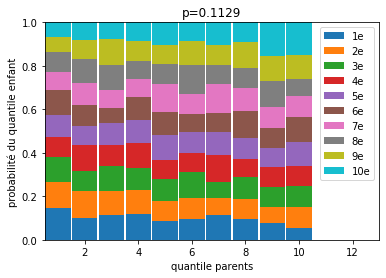

In [98]:
pj = 0.1129             # coefficient d'élasticité du pays j
nb_quantiles = 10       # nombre de quantiles (nombre de classes de revenu)
n  = 500*nb_quantiles   # taille de l'échantillon
p = 0.1129

y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
plt_final = plot_conditional_distributions(p, cd, nb_quantiles)
plt_final

In [99]:
# Graphique faible mobilité (p(max) = 1.0954)
pmax = data_gini[data_gini['IGEincome'] == 1.0954]
pmax

,country,quantile,income,gdpppp,Area,IGEincome,Gini
2098,COL,99,22631.8070,8185.0,Colombia,1.0954,55.433333
2035,COL,36,1335.3099,8185.0,Colombia,1.0954,55.433333
2025,COL,26,1011.2626,8185.0,Colombia,1.0954,55.433333
2026,COL,27,1015.4744,8185.0,Colombia,1.0954,55.433333
2027,COL,28,1046.8031,8185.0,Colombia,1.0954,55.433333
...,...,...,...,...,...,...,...
2067,COL,68,3036.2990,8185.0,Colombia,1.0954,55.433333
2068,COL,69,3095.7312,8185.0,Colombia,1.0954,55.433333
2069,COL,70,3199.9040,8185.0,Colombia,1.0954,55.433333
2070,COL,71,3301.3682,8185.0,Colombia,1.0954,55.433333


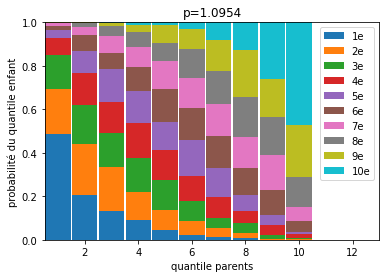

In [100]:
pj = 1.0954             # coefficient d'élasticité du pays j
nb_quantiles = 10       # nombre de quantiles (nombre de classes de revenu)
n  = 500*nb_quantiles   # taille de l'échantillon
p = 1.0954

y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
plt_final = plot_conditional_distributions(p, cd, nb_quantiles)
plt_final

## 5) Création de la classe parents <a class="anchor" id="section_4_5"></a>

In [101]:
GDIM_categ = GDIM.copy()
GDIM_categ = GDIM_categ.drop_duplicates()
GDIM_categ

,Area,IGEincome
0,Albania,0.8159
100,Argentina,0.6600
200,Armenia,0.5000
300,Austria,0.2453
400,Azerbaijan,0.5000
...,...,...
11099,Vietnam,0.4800
11199,West Bank and Gaza,0.6600
11299,"Yemen, Rep.",0.6600
11399,South Africa,0.6770


In [102]:
classe_R = pd.DataFrame(columns=["y_child", "y_parents", "c_i_child","c_i_parent",'Area'])
classe_R

for i in GDIM_categ['Area']:
    nb_quantiles = 100
    n  = 500*nb_quantiles
    pj = GDIM_categ[(GDIM_categ["Area"] == i)]['IGEincome'].values
    y_child, y_parents = generate_incomes(n, pj)
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    Area = pd.Series(i, range(50000))
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent, Area], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent",'Area']
    classe_R = classe_R.append(sample)
    
classe_R

,y_child,y_parents,c_i_child,c_i_parent,Area
0,0.201753,0.452723,11,22,Albania
1,4.596304,1.459825,88,65,Albania
2,0.208231,1.539715,12,67,Albania
3,0.552514,0.258586,32,9,Albania
4,1.955944,1.721874,70,71,Albania
...,...,...,...,...,...
49995,2.926629,5.058305,81,95,"Congo, Dem. Rep."
49996,0.805862,1.703669,44,71,"Congo, Dem. Rep."
49997,0.127606,0.337602,5,14,"Congo, Dem. Rep."
49998,1.798913,1.887475,69,74,"Congo, Dem. Rep."


In [103]:
classe_R.loc[:,['c_i_parent']] = classe_R['c_i_parent'].astype(int)
classe_R = classe_R.loc[:,["c_i_child",'c_i_parent','Area']]

In [104]:
# Comparaison distribution conditionnel du nouvel échantillon FR généré avec celui donné 

GDIM_FR = 0.3571
nb_quantiles = 100
n  = 5000*nb_quantiles
y_child, y_parents = generate_incomes(n, GDIM_FR)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
sample = sample.groupby(['c_i_child']).mean()
sample

,y_child,y_parents,c_i_parent
c_i_child,,,
1,0.061961,0.640336,25.9930
2,0.099766,0.759157,30.4490
3,0.125036,0.802028,32.1450
4,0.146419,0.835040,33.0996
5,0.166055,0.902534,34.6716
...,...,...,...
96,6.061339,2.677268,66.9144
97,6.860729,2.860912,67.8364
98,8.020894,2.975663,69.1040


In [105]:
classe_FR = classe_R.copy()
classe_FR = classe_FR[classe_FR['Area'] == 'France']
classe_FR = classe_FR.groupby(['c_i_child']).mean()
classe_FR

,c_i_parent
c_i_child,
1,26.274
2,32.006
3,31.948
4,34.236
5,34.126
...,...
96,66.688
97,66.872
98,68.276


La comparaison est similaire, nous pouvons donc valider la boucle

# V. Mission 4 <a class="anchor" id="chapter5"></a>

## 1) ANOVA area - Income <a class="anchor" id="section_5_1"></a>

In [106]:
IGEincome = classe_R.copy()
IGEincome.rename(columns={'c_i_child': 'quantile'}, inplace=True)
data_gini_IGEi = data_gini.copy()
data_gini_IGEi = pd.merge(data_gini_IGEi, IGEincome, on = ['Area', 'quantile'], how='inner')
data_ANOVA = data_gini_IGEi.loc[:,['Area', 'income']]
data_ANOVA = data_ANOVA.drop_duplicates()
data_ANOVA

,Area,income
0,Colombia,22631.8070
500,Colombia,1335.3099
1000,Colombia,1011.2626
1500,Colombia,1015.4744
2000,Colombia,1046.8031
...,...,...
5797500,Finland,17835.3830
5798000,Finland,18088.0920
5798500,Finland,18311.2440
5799000,Finland,18546.1270


In [107]:
# ANOVA

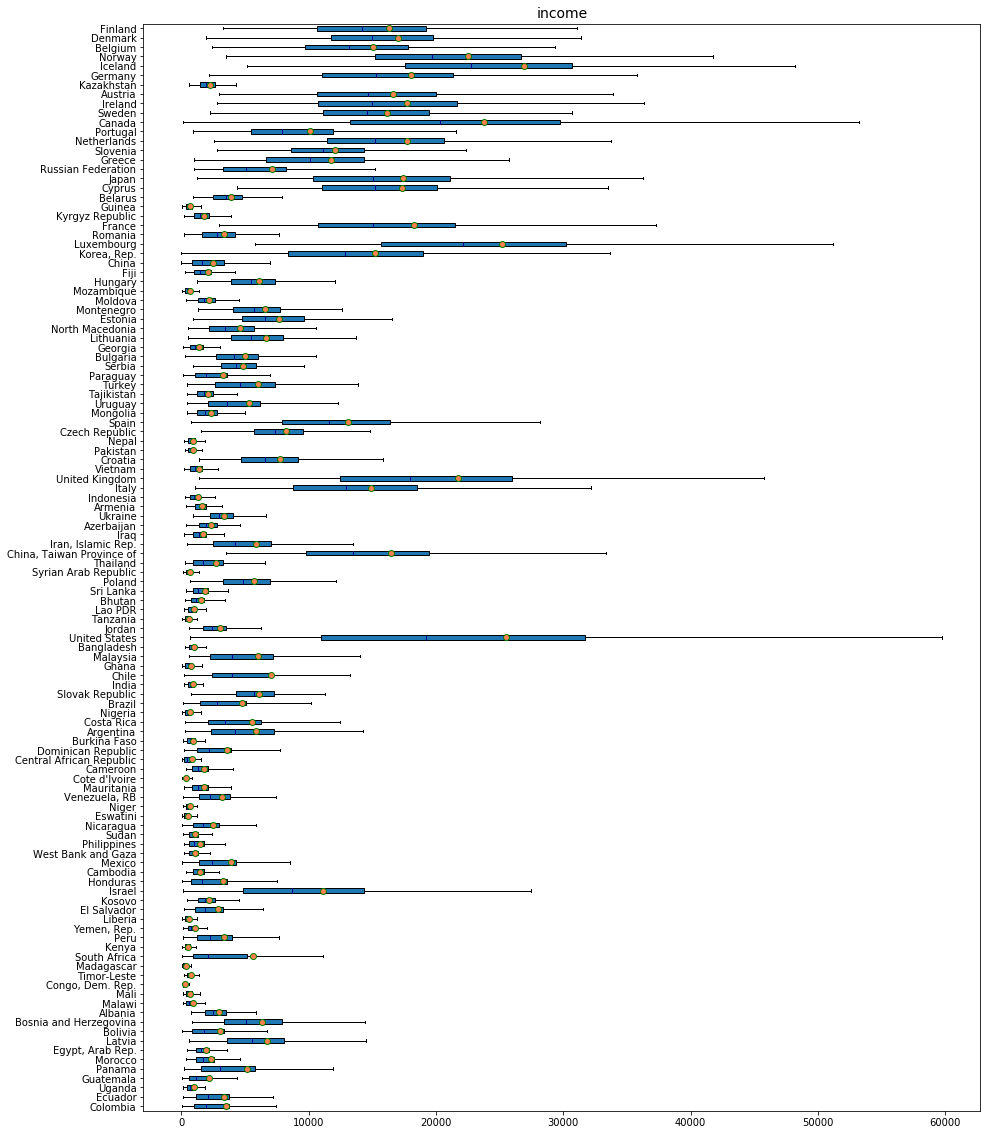

In [108]:
X = "Area"   # qualitative
Y = "income" # quantitative

modalites = data_ANOVA[X].unique()
groupes = []
for m in modalites:
    groupes.append(data_ANOVA[data_ANOVA[X]==m][Y])


medianprops = {'color':"DarkBlue"}
meanprops = {'marker':'o', 'markeredgecolor':'Green',
            'markerfacecolor':'coral'}
plt.figure(figsize=(15, 20))
plt.title('income',fontsize=14) 
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

In [109]:
anova_income = smf.ols('income~Area', data=data_ANOVA).fit()
print(anova_income.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     98.43
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        01:43:29   Log-Likelihood:            -1.1862e+05
No. Observations:               11600   AIC:                         2.375e+05
Df Residuals:                   11484   BIC:                         2.383e+05
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

0,496 très élevé, à partir de 0,12 on conclut qu'il y a une correlation donc 49,6% de l'income est attribué au facteur pays de l'icome.

On y voit les paramètres estimés (dans la colonne "Estimate"), mais ici, ce ne sont pas les paramètres qui nous intéressent le plus.

#### Test de Fisher

Ce qui nous intéresse réellement, c'est le **test de Fisher**.
La p-valeur de ce test 0.00 est très petite et largement inférieure à 5 %. On rejette donc l'hypothèse H0 qui est que le revenu ne dépend pas du pays d'origine.

*Le pays d'origine a donc bien un effet sur les revenus, comme nous en avions l'intuition en regardant les boîtes à moustaches.*

Pour obtenir le tableau de l'analyse de la variance, on utilise la commande anova_lm :

In [110]:
sm.stats.anova_lm(anova_income, typ=2)

,sum_sq,df,F,PR(>F)
Area,5.102381e+11,115.0,98.429651,0.0
Residual,5.176572e+11,11484.0,NaN,NaN


Voir s'il y a une correlation entre income et Area -> PR = 0 donc hypothèse H0 égalité des variances rejetée donc modèle valide 

#### Testez l’homoscédasticité
On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :

In [111]:
variables = anova_income.model.exog
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(anova_income.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 4.7245183909955795e-37


La p-valeur ici est inférieure à $5$%, on rejette donc l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

#### Testez la normalité des résidus

Si l'on veut tester la normalité des résidus, on peut faire un test de Shapiro-Wilk.

In [112]:
shapiro(anova_income.resid)

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.5609959363937378, 0.0)

Ici, l'hypothèse de normalité est remise en cause (p-value = 0.000 < 0.05).

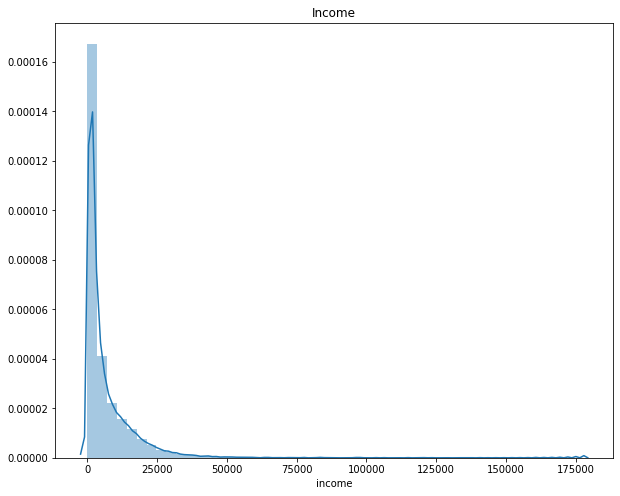

In [113]:
plt.figure(figsize=(10, 8))
sns.distplot(data_ANOVA["income"]).set_title("Income")
plt.show()

Concentré à gauche c'est pourquoi on a transformé en version log pour que ce soit Gaussien

In [114]:
ks_2samp(data_ANOVA["income"],list(np.random.normal(np.mean(data_ANOVA["income"]), np.std(data_ANOVA["income"]), 1000)))


Ks_2sampResult(statistic=0.2483103448275862, pvalue=9.9079315344183e-50)

pvalue < 0,05 = 5% -> On peut donc rejeter l’hypothèse de normalité au niveau de test 5%

## 2) ANOVA area - income_log <a class="anchor" id="section_5_2"></a>

In [115]:
data_ANOVA['income_log'] = np.log(data_ANOVA['income'])

anova_income_log = smf.ols('income_log~Area', data=data_ANOVA).fit()
print(anova_income_log.summary())

                            OLS Regression Results                            
Dep. Variable:             income_log   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     269.0
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        01:43:29   Log-Likelihood:                -12627.
No. Observations:               11600   AIC:                         2.549e+04
Df Residuals:                   11484   BIC:                         2.634e+04
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

0.729 très élevé, à partir de 0,12 on conclut qu'il y a une correlation donc 72,9% de l'income est attribué au facteur pays de l'income_log.

Pour obtenir le tableau de l'analyse de la variance, on utilise la commande anova_lm :

In [116]:
sm.stats.anova_lm(anova_income_log, typ=2)

,sum_sq,df,F,PR(>F)
Area,16134.561627,115.0,268.956393,0.0
Residual,5990.604405,11484.0,NaN,NaN


Déterminer si il y a une correlation entre income et Area -> PR = 0 donc hypothèse H0 égalité des variances rejetée donc modèle valide 


#### Testez l’homoscédasticité
On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :

In [117]:
variables = anova_income_log.model.exog
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(anova_income_log.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 9.29765397845685e-101


La p-valeur ici est inférieure à $5$%, on rejette donc l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

#### Testez la normalité des résidus

Si l'on veut tester la normalité des résidus, on peut faire un test de Shapiro-Wilk.

In [118]:
shapiro(anova_income_log.resid)

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9785946011543274, 2.533319492109277e-38)

Ici, l'hypothèse de normalité est remise en cause (p-value < 0.05).

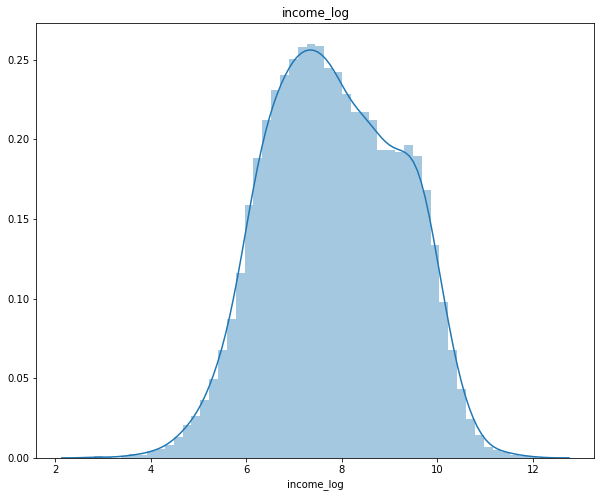

In [119]:
plt.figure(figsize=(10, 8))
sns.distplot(data_ANOVA["income_log"]).set_title("income_log")
plt.show()

-> Distribution bien symétrique

In [120]:
ks_2samp(data_ANOVA["income_log"],list(np.random.normal(np.mean(data_ANOVA["income_log"]), np.std(data_ANOVA["income_log"]), 1000)))


Ks_2sampResult(statistic=0.07287931034482759, pvalue=0.00011317648097202878)

pvalue < 0,05 = 5% -> On peut donc rejeter l’hypothèse de normalité au niveau de test 5%

## 3) Régression linéaire income_log ~ gdpppp_log + Gini <a class="anchor" id="section_5_3"></a>

In [121]:
# Préparation des données pour les régressions linéaires multiples

data_gini_log = data_gini_IGEi.copy()
data_gini_log['income_log'] = np.log(data_gini_log['income'])
data_gini_log['gdpppp_log'] = np.log(data_gini_log['gdpppp'])
data_gini_log

,country,quantile,income,gdpppp,Area,IGEincome,Gini,c_i_parent,income_log,gdpppp_log
0,COL,99,22631.807,8185.0,Colombia,1.0954,55.433333,91,10.027112,9.010058
1,COL,99,22631.807,8185.0,Colombia,1.0954,55.433333,92,10.027112,9.010058
2,COL,99,22631.807,8185.0,Colombia,1.0954,55.433333,100,10.027112,9.010058
3,COL,99,22631.807,8185.0,Colombia,1.0954,55.433333,98,10.027112,9.010058
4,COL,99,22631.807,8185.0,Colombia,1.0954,55.433333,97,10.027112,9.010058
...,...,...,...,...,...,...,...,...,...,...
5799995,FIN,50,14104.846,33626.0,Finland,0.1129,27.744444,95,9.554274,10.423055
5799996,FIN,50,14104.846,33626.0,Finland,0.1129,27.744444,44,9.554274,10.423055
5799997,FIN,50,14104.846,33626.0,Finland,0.1129,27.744444,51,9.554274,10.423055
5799998,FIN,50,14104.846,33626.0,Finland,0.1129,27.744444,14,9.554274,10.423055


In [122]:
# Préparation des données pour la régression linéaire multiple à 2 variables explicatives

test_2variables = data_gini_log.copy()
test_2variables = test_2variables.loc[:,["income_log",'gdpppp_log','Gini']]
test_2variables = test_2variables.drop_duplicates()
test_2variables

,income_log,gdpppp_log,Gini
0,10.027112,9.010058,55.433333
500,7.196919,9.010058,55.433333
1000,6.918955,9.010058,55.433333
1500,6.923111,9.010058,55.433333
2000,6.953496,9.010058,55.433333
...,...,...,...
5797500,9.788940,10.423055,27.744444
5798000,9.803009,10.423055,27.744444
5798500,9.815271,10.423055,27.744444
5799000,9.828016,10.423055,27.744444


In [123]:
reg_multi = smf.ols('income_log~gdpppp_log+Gini', data=test_2variables).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             income_log   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                 1.097e+04
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        01:43:31   Log-Likelihood:                -14047.
No. Observations:               11600   AIC:                         2.810e+04
Df Residuals:                   11597   BIC:                         2.812e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9712      0.077     12.636      0.0

In [124]:
test_2variables['residus'] = reg_multi.resid
test_2variables

,income_log,gdpppp_log,Gini,residus
0,10.027112,9.010058,55.433333,2.319142
500,7.196919,9.010058,55.433333,-0.511051
1000,6.918955,9.010058,55.433333,-0.789015
1500,6.923111,9.010058,55.433333,-0.784859
2000,6.953496,9.010058,55.433333,-0.754474
...,...,...,...,...
5797500,9.788940,10.423055,27.744444,0.364645
5798000,9.803009,10.423055,27.744444,0.378715
5798500,9.815271,10.423055,27.744444,0.390976
5799000,9.828016,10.423055,27.744444,0.403722


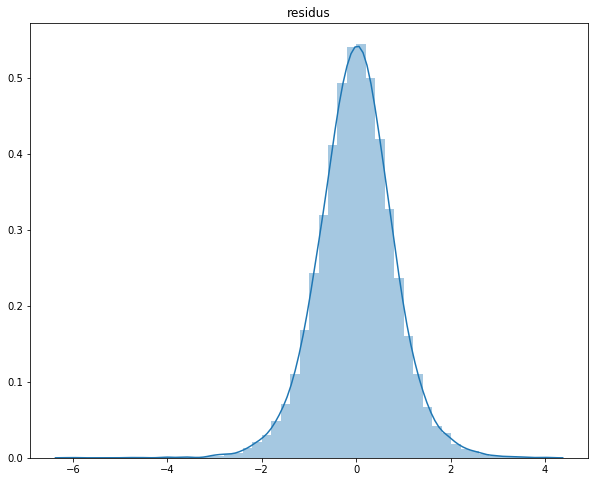

In [125]:
plt.figure(figsize=(10, 8))
sns.distplot(reg_multi.resid).set_title("residus")
plt.show()

Nous allons ici réaliser les tests à un niveau $\alpha=5$% :

In [126]:
alpha = 0.05

Récupérons $n$, le nombre d'individus de l'échantillon, et $p$, le nombre de variables.

In [127]:
n = test_2variables.shape[0]
p = 2

In [128]:
n 

11600

Nous allons mener des analyses sur les valeurs atypiques et/ou influentes en travaillant sur un dataframe appelé  analyses.

In [129]:
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})
#analyses['obs'].astype('float', inplace=True)
analyses.describe(include='all')

,obs
count,11600.000000
mean,5800.500000
std,3348.775896
min,1.000000
25%,2900.750000
50%,5800.500000
75%,8700.250000
max,11600.000000


### Les leviers

On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de $2∗\frac{p}{n}$.

In [130]:
analyses['levier'] = reg_multi.get_influence().hat_matrix_diag

seuil_levier = 2*p/n

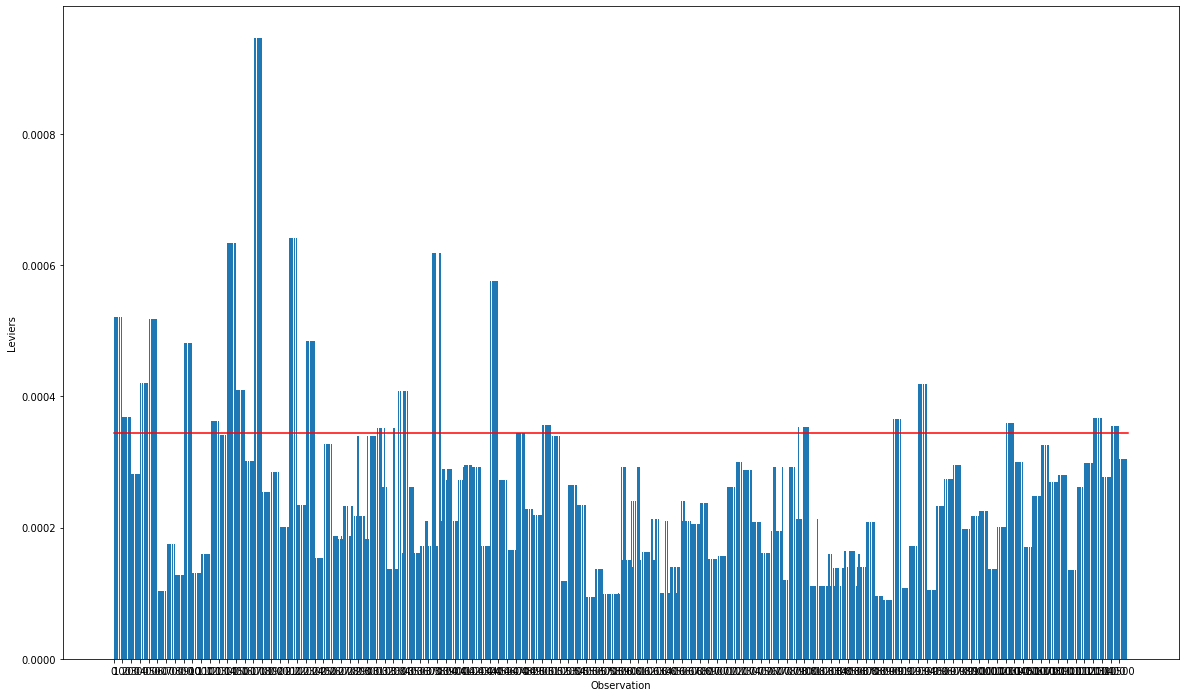

In [131]:
plt.figure(figsize=(20,12))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, 11600, step=100))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 11600], [seuil_levier, seuil_levier], color='r')
plt.show()

In [132]:
analyses.loc[analyses['levier'] > seuil_levier, :]

,obs,levier
0,1,0.000520
1,2,0.000520
2,3,0.000520
3,4,0.000520
4,5,0.000520
...,...,...
11495,11496,0.000354
11496,11497,0.000354
11497,11498,0.000354
11498,11499,0.000354


### Les résidus studentisés

Si l'on souhaite maintenant calculer les résidus studentisés, nous écrivons ceci, sachant que le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté :

In [133]:
analyses['rstudent'] = reg_multi.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

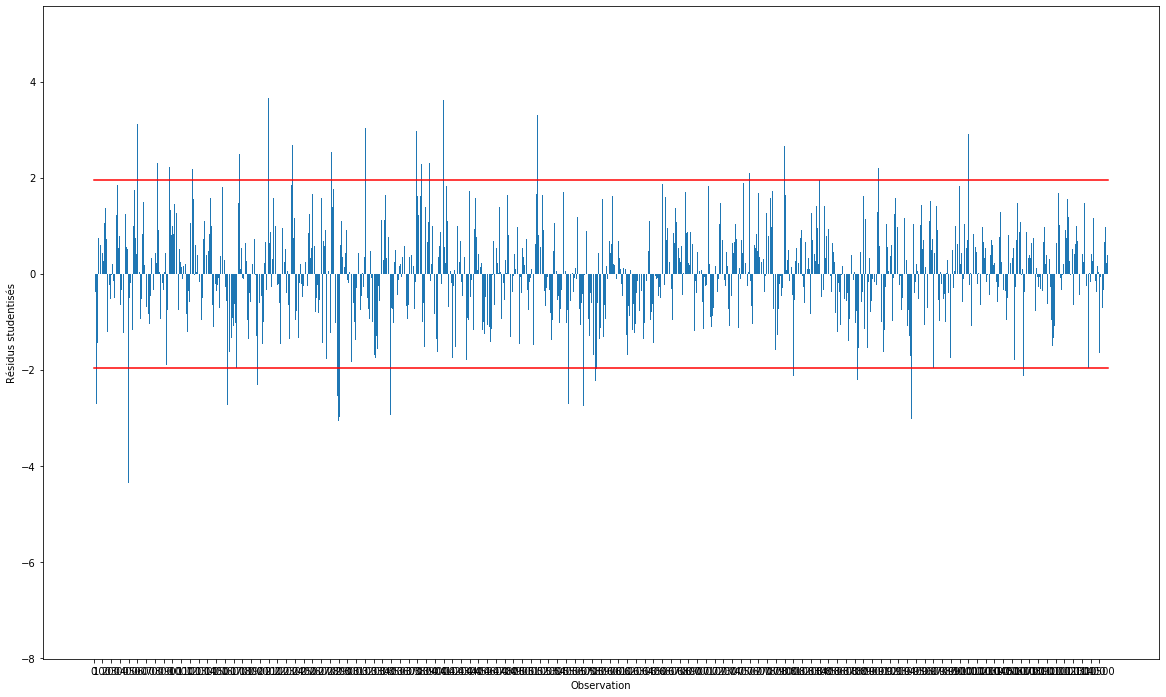

In [134]:
plt.figure(figsize=(20,12))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, 11600, step=100))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 11600], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 11600], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

### La distance de Cook

Pour trouver la distance de Cook, nous exécutons ceci :

In [135]:
influence = reg_multi.get_influence().summary_frame()

Le seuil de la distance de Cook est de n-p. 

In [136]:
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

On peut détecter les observations influentes comme ceci :

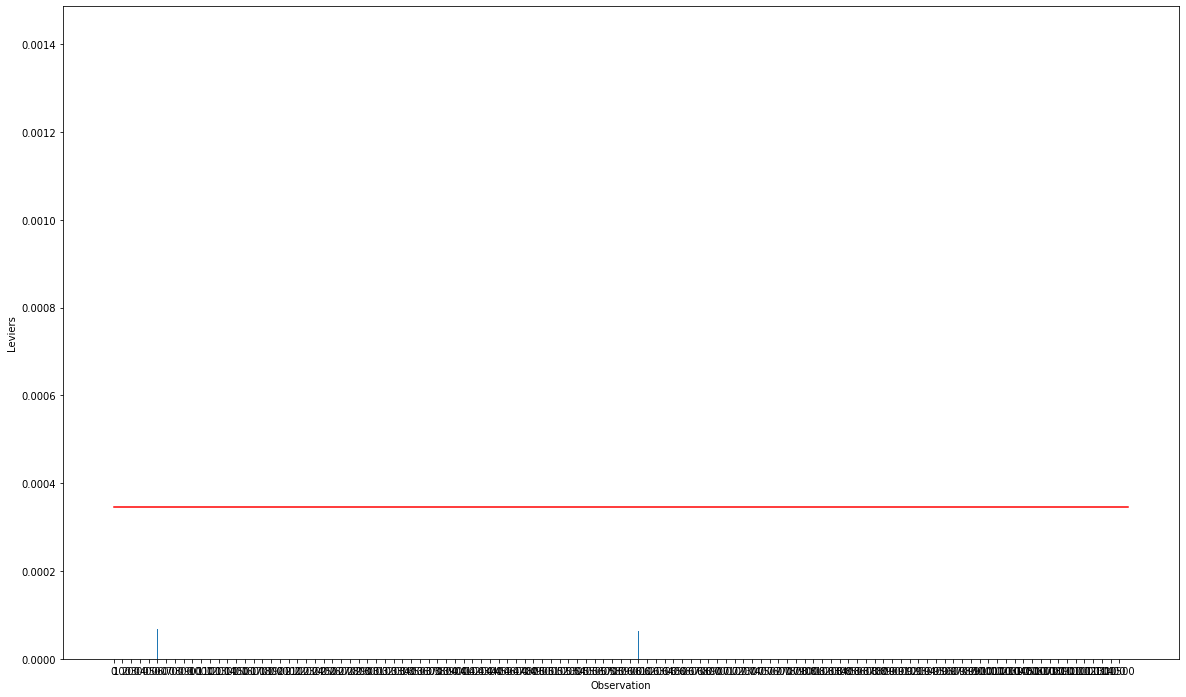

In [137]:
plt.figure(figsize=(20,12))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, 11600, step=100))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 11600], [seuil_dcook, seuil_dcook], color='r')
plt.show()

On ne retire des points qu'après avoir vérifié qu'ils sont effectivement atypiques, voire aberrants, au vu du modèle estimé.

### La colinéarité des variables

Une autre chose à vérifier est l'éventuelle colinéarité approchée des variables :

In [138]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.1091360786929438, 1.109136078692944]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

#### Testez l’homoscédasticité
On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :

In [139]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 1.7129117408008192e-125


La p-valeur ici est inférieure à $5$%, on rejette donc l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

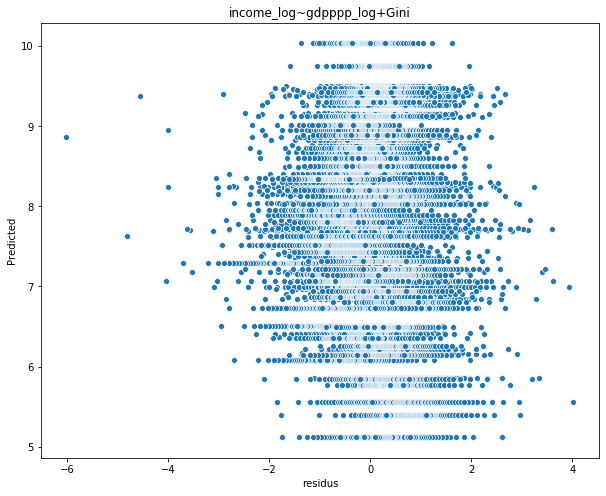

In [140]:
# Plot Predicted values VS Residus

plt.figure(figsize=(10, 8))
test_2variables['Predicted'] = reg_multi.predict()
test_2variables['residus'] = reg_multi.resid
ax = sns.scatterplot(x="residus", y="Predicted", data=test_2variables)
ax.set(xlabel='residus', ylabel='Predicted')
plt.title('income_log~gdpppp_log+Gini')
plt.show()

#### Testez la normalité des résidus

Si l'on veut tester la normalité des résidus, on peut faire un test de Shapiro-Wilk.

In [141]:
shapiro(reg_multi.resid)

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9902801513671875, 2.4085281217008283e-27)

Ici, l'hypothèse de normalité est remise en cause (p-value = < 0.05).

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que **les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes**, même si le résidu n'est pas considéré comme étant gaussien.

In [142]:
## 4) Régression linéaire income ~ gdpppp_log + Gini <a class="anchor" id="section_5_4"></a>

In [143]:
reg_multi = smf.ols('income~gdpppp+Gini', data=data_gini_log).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                 2.348e+06
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        01:44:37   Log-Likelihood:            -5.9579e+07
No. Observations:             5800000   AIC:                         1.192e+08
Df Residuals:                 5799997   BIC:                         1.192e+08
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -72.1456     16.352     -4.412      0.0

F - stat prob = 0 donc égalité des variances rejeté donc modèle significatif  
P > t = 0 * 3 donc concluant = test de student, significalité des paramètres - HO = coef est nul 0.4819 et 4.7120 - si coef égal zéro alors la variable n'a rien à faire dans ce test.

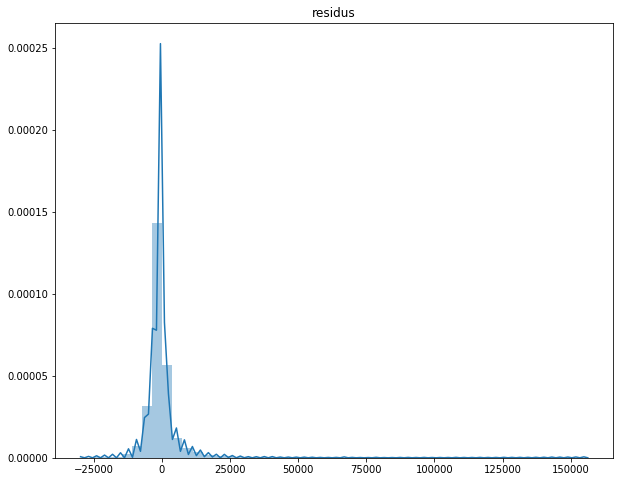

In [144]:
plt.figure(figsize=(10, 8))
sns.distplot(reg_multi.resid).set_title("residus")
plt.show()

### Vérifier la colinéarité des variables

Une autre chose à vérifier est l'éventuelle colinéarité approchée des variables :

In [145]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.1937693278686659, 1.1937693278684662]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

#### Testez l’homoscédasticité
On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :

In [146]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 0.0


La p-valeur ici est inférieure à $5$%, on rejette donc l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).


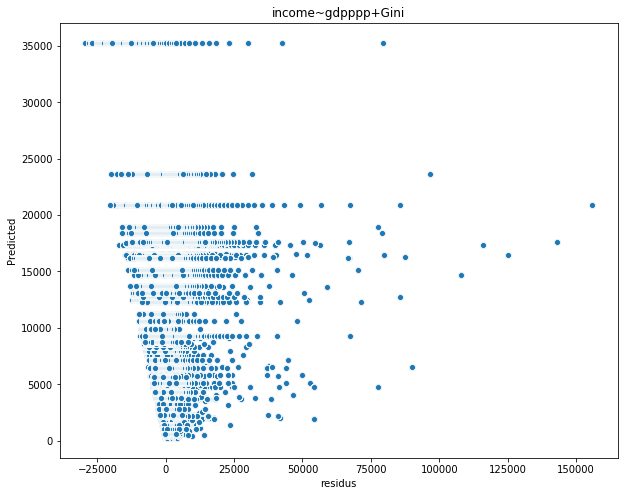

In [147]:
# Plot Predicted values VS Residus

plt.figure(figsize=(10, 8))
data_gini_log['Predicted'] = reg_multi.predict()
data_gini_log['residus'] = reg_multi.resid
ax = sns.scatterplot(x="residus", y="Predicted", data=data_gini_log)
ax.set(xlabel='residus', ylabel='Predicted')
plt.title('income~gdpppp+Gini')
plt.show()

#### Testez la normalité des résidus

Si l'on veut tester la normalité des résidus, on peut faire un test de Shapiro-Wilk.

In [148]:
shapiro(reg_multi.resid)

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.5759292840957642, 0.0)

Ici, l'hypothèse de normalité est remise en cause (p-value = 0.0 < 0.05).

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que **les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes**, même si le résidu n'est pas considéré comme étant gaussien.

In [149]:
# Regression linéaire logarithme avec classe de revenus des parents

reg_multi = smf.ols('income_log~gdpppp_log +Gini+c_i_parent', data=data_gini_log).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             income_log   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                 4.643e+06
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        01:45:11   Log-Likelihood:            -6.5522e+06
No. Observations:             5800000   AIC:                         1.310e+07
Df Residuals:                 5799996   BIC:                         1.310e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4208      0.003    130.895      0.0

F - stat prob = 0 donc égalité des variances rejeté donc modèle significatif  
P > t = 0 * 3 donc concluant = test de student  
Plus R-squared élevé plus le modèle est robuste  
Plus il y a de variables explicatives, plus R-squared est élevé  
R-squared plus élevé avec variable log 

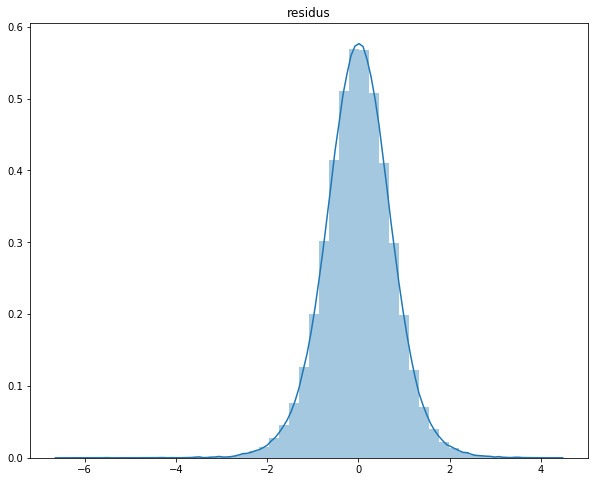

In [150]:
plt.figure(figsize=(10, 8))
sns.distplot(reg_multi.resid).set_title("residus")
plt.show()

### Vérifier la colinéarité des variables

Une autre chose à vérifier est l'éventuelle colinéarité approchée des variables :

In [151]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.1091360786929279, 1.1091360786931053, 1.0000000000000009]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

#### Testez l’homoscédasticité
On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :

In [152]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 0.0


La p-valeur ici est inférieure à $5$%, on rejette donc l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

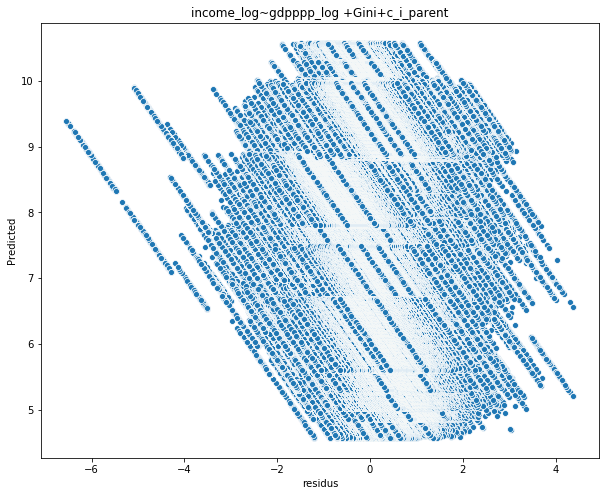

In [153]:
# Plot Predicted values VS Residus

plt.figure(figsize=(10, 8))
data_gini_log['Predicted'] = reg_multi.predict()
data_gini_log['residus'] = reg_multi.resid
ax = sns.scatterplot(x="residus", y="Predicted", data=data_gini_log)
ax.set(xlabel='residus', ylabel='Predicted')
plt.title('income_log~gdpppp_log +Gini+c_i_parent')
plt.show()

#### Testez la normalité des résidus

Si l'on veut tester la normalité des résidus, on peut faire un test de Shapiro-Wilk.

In [154]:
shapiro(reg_multi.resid)

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9910811185836792, 0.0)

Ici, l'hypothèse de normalité est remise en cause (p-value = 0.0 < 0.05).

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que **les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes**, même si le résidu n'est pas considéré comme étant gaussien.